# SLAMseq

## Installing slamdunk (only do once)

In [1]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [2]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

In [2]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
import seaborn as sns
import numpy as np

from natsort import os_sorted

from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

from bokeh.plotting import *
from bokeh.models import HoverTool
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

output_notebook()
%load_ext autoreload
%matplotlib inline
%autoreload 2
%load_ext rpy2.ipython

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)

# Inhibitors_v1 (no alt loci)

In [4]:
project = "inhibitors_v1"

### download the data

In [4]:
location = "../data/slamseq_"+project+"/" # new data location
loc = "211217_MP9543_fastq" # transfer AML folder

In [5]:
! mkdir ../$location
! mkdir ../results/slamseq_$project
! mkdir $location && mkdir $location/qc # make data dir in AMLproject
! mkdir ../$location/fastqs/ # make dir in /home/monika/data/project/fastqs

In [6]:
! gsutil ls gs://transfer-amlproject/$loc/

gs://transfer-amlproject/211217_MP9543_fastq/20211217_10_MP9543_S90_R1_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_10_MP9543_S90_R2_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_11_MP9543_S91_R1_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_11_MP9543_S91_R2_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_12_MP9543_S92_R1_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_12_MP9543_S92_R2_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_13_MP9543_S93_R1_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_13_MP9543_S93_R2_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_14_MP9543_S94_R1_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_14_MP9543_S94_R2_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_15_MP9543_S95_R1_001.fastq.gz
gs://transfer-amlproject/211217_MP9543_fastq/20211217_15_MP9543_S95_R2_001.f

In [7]:
# transfer qc files
! gsutil -m cp gs://transfer-amlproject/$loc/multiqc_report.html $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/Reports/ $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/multiqc_data/ $location/qc/

Copying gs://transfer-amlproject/211217_MP9543_fastq/multiqc_report.html...
/ [1/1 files][  1.6 MiB/  1.6 MiB] 100% Done                                    
Operation completed over 1 objects/1.6 MiB.                                      
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_10_MP9543_S90_R1_001_fastqc.html...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_10_MP9543_S90_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_10_MP9543_S90_R2_001_fastqc.html...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_10_MP9543_S90_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_11_MP9543_S91_R1_001_fastqc.html...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_11_MP9543_S91_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_11_MP9543_S91_R2_001_fastqc.html...
Copying gs://transfer-

Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_30_MP9543_S49_R1_001_fastqc.html...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_30_MP9543_S49_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_30_MP9543_S49_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_30_MP9543_S49_R2_001_fastqc.html...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_3_MP9543_S83_R1_001_fastqc.html...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_3_MP9543_S83_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_3_MP9543_S83_R2_001_fastqc.html...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_3_MP9543_S83_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Reports/20211217_4_MP9543_S84_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/211217_MP9543_fastq/Rep

In [8]:
! cp $location/qc/multiqc_report.html ../results/slamseq_$project

In [9]:
fastqs = ! gsutil ls gs://transfer-amlproject/$loc/*.gz

In [11]:
fastqs = [fastq.split("/")[-1] for fastq in os_sorted(fastqs)]

In [12]:
for val1, val2 in h.grouped(fastqs, 2):
    print(val1.split("_R")[0])

20211217_1_MP9543_S81
20211217_2_MP9543_S82
20211217_3_MP9543_S83
20211217_4_MP9543_S84
20211217_5_MP9543_S85
20211217_6_MP9543_S86
20211217_7_MP9543_S87
20211217_8_MP9543_S88
20211217_9_MP9543_S89
20211217_10_MP9543_S90
20211217_11_MP9543_S91
20211217_12_MP9543_S92
20211217_13_MP9543_S93
20211217_14_MP9543_S94
20211217_15_MP9543_S95
20211217_16_MP9543_S96
20211217_17_MP9543_S39
20211217_18_MP9543_S40
20211217_19_MP9543_S41
20211217_20_MP9543_S42
20211217_21_MP9543_S43
20211217_22_MP9543_S44
20211217_23_MP9543_S45
20211217_24_MP9543_S46
20211217_26_MP9543_S47
20211217_28_MP9543_S48
20211217_30_MP9543_S49


In [13]:
! gsutil -m cp gs://transfer-amlproject/$loc/*.fastq.gz ../$location/fastqs/ # transfer fastqs

Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_10_MP9543_S90_R1_001.fastq.gz...
Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_10_MP9543_S90_R2_001.fastq.gz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_11_MP9543_S91_R1_001.fastq.gz...
Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_11_MP9543_S91_R2_001.fastq.gz...
Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_12_MP9543_S92_R1_001.fastq.gz...
Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_12_MP9543_S92_R2_001.fastq.gz...
Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_13_MP9543_S93_R1_001.fastq.gz...
Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_13_MP9543_S93_R2

### rename local fastqs

In [104]:
location = "../data/slamseq_"+project+"/" # new data location
loc = "211217_MP9543_fastq" # transfer AML folder

In [105]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder
fastqs = os_sorted(fastqs)

../../data/slamseq_inhibitors_v1/fastqs


In [106]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

In [109]:
# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == project] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["prev_name", "name"]]
print(sample_info.shape)
sample_info.head()

(30, 2)


,prev_name,name
491,20211217_1_MP9543_S81,mr492-MV411-DMSO-r1
492,20211217_2_MP9543_S82,mr493-MV411-DMSO-r2
493,20211217_3_MP9543_S83,mr494-MV411-DMSO-r3
494,20211217_4_MP9543_S84,mr495-MV411-DMSO-r4
495,20211217_5_MP9543_S85,mr496-MV411-DMSO-r5


In [108]:
if sample_info.shape[0] != len(fastqs)/2:
    raise ValueError("Sample info and fastqs not the same number of samples.")

In [109]:
# make dict with names
rename = dict(zip(sample_info.prev_name, sample_info.name))

In [110]:
any(prev_name in fastq for fastq in fastqs for prev_name in list(rename.keys()))

False

In [112]:
rename

{'20211217_1_MP9543_S81': 'mr492-MV411-DMSO-r1',
 '20211217_2_MP9543_S82': 'mr493-MV411-DMSO-r2',
 '20211217_3_MP9543_S83': 'mr494-MV411-DMSO-r3',
 '20211217_4_MP9543_S84': 'mr495-MV411-DMSO-r4',
 '20211217_5_MP9543_S85': 'mr496-MV411-DMSO-r5',
 '20211217_6_MP9543_S86': 'mr497-MV411-Naphthol-r1',
 '20211217_7_MP9543_S87': 'mr498-MV411-Naphthol-r2',
 '20211217_8_MP9543_S88': 'mr499-MV411-Naphthol-r3',
 '20211217_9_MP9543_S89': 'mr500-MV411-Naphthol-r4',
 '20211217_10_MP9543_S90': 'mr501-MV411-Naphthol-r5',
 '20211217_11_MP9543_S91': 'mr502-MV411-Plumbagin-r1',
 '20211217_12_MP9543_S92': 'mr503-MV411-Plumbagin-r2',
 '20211217_13_MP9543_S93': 'mr504-MV411-Plumbagin-r3',
 '20211217_14_MP9543_S94': 'mr505-MV411-Plumbagin-r4',
 '20211217_15_MP9543_S95': 'mr506-MV411-Plumbagin-r5',
 '20211217_16_MP9543_S96': 'mr507-MV411-Celastrol-r1',
 '20211217_17_MP9543_S39': 'mr508-MV411-Celastrol-r2',
 '20211217_18_MP9543_S40': 'mr509-MV411-Celastrol-r3',
 '20211217_19_MP9543_S41': 'mr510-MV411-Celastrol

In [76]:
# rename fastqs locally
for val in fastqs:
    print(val)
    rep  = val
    for old, new in rename.items():
        if old not in rep:
            break
        rep = rep.replace(old, new)
    print("\n")
    #if rep != val:
        #! mv $fastq_folder/$val $fastq_folder/$rep

../../data/slamseq_inhibitors_v1/fastqs/20211217_3_MP9543_S83_R1_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/20211217_3_MP9543_S83_R2_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R1_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R2_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr493-MV411-DMSO-r2_R1_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr493-MV411-DMSO-r2_R2_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr495-MV411-DMSO-r4_R1_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr495-MV411-DMSO-r4_R2_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr496-MV411-DMSO-r5_R1_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr496-MV411-DMSO-r5_R2_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr497-MV412-Naphthol-r1_R1_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr497-MV412-Naphthol-r1_R2_001.fastq.gz


../../data/slamseq_inhibitors_v1/fastqs/mr498-MV413-

### extra samples (download & rename)

In [186]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

In [187]:
# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == project] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["ID", "prev_name", "name"]]
print(sample_info.shape)
sample_info.head()

(30, 3)


,ID,prev_name,name
491,mr492,20211217_1_MP9543_S81,mr492-MV411-DMSO-r1
492,mr493,20211217_2_MP9543_S82,mr493-MV411-DMSO-r2
493,mr494,20211217_3_MP9543_S83,mr494-MV411-DMSO-r3
494,mr495,20211217_4_MP9543_S84,mr495-MV411-DMSO-r4
495,mr496,20211217_5_MP9543_S85,mr496-MV411-DMSO-r5


In [198]:
rename = sample_info.iloc[24:]
rename

,ID,prev_name,name
515,mr516,20211222_25R_MP9543R_S106,mr516-MV412-TM1-001-r5
516,mr517,20211217_26_MP9543_S47,mr517-MV413-Tretinoin-r1
517,mr518,20211222_27R_MP9543R_S107,mr518-MV414-Tretinoin-r2
518,mr519,20211217_28_MP9543_S48,mr519-MV415-Tretinoin-r3
519,mr520,20211222_29R_MP9543R_S108,mr520-MV416-Tretinoin-r4
520,mr521,20211217_30_MP9543_S49,mr521-MV417-Tretinoin-r5


In [188]:
# remote fastqs
remote_fastqs = ! gsutil ls gs://transfer-amlproject/$loc/*.gz
remote_fastqs = [fastq.split("/")[-1] for fastq in os_sorted(remote_fastqs)]

In [190]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder/*fastq.gz
fastqs = os_sorted(fastqs)

../../data/slamseq_inhibitors_v1/fastqs


In [200]:
# remote fastqs to download
remote_fastqs = [remote_fastq for remote_fastq in remote_fastqs if 
                 any(prev_name in remote_fastq for prev_name in rename["prev_name"])]
remote_fastqs

['20211217_26_MP9543_S47_R1_001.fastq.gz',
 '20211217_26_MP9543_S47_R2_001.fastq.gz',
 '20211217_28_MP9543_S48_R1_001.fastq.gz',
 '20211217_28_MP9543_S48_R2_001.fastq.gz',
 '20211217_30_MP9543_S49_R1_001.fastq.gz',
 '20211217_30_MP9543_S49_R2_001.fastq.gz',
 '20211222_25R_MP9543R_S106_R1_001.fastq.gz',
 '20211222_25R_MP9543R_S106_R2_001.fastq.gz',
 '20211222_27R_MP9543R_S107_R1_001.fastq.gz',
 '20211222_27R_MP9543R_S107_R2_001.fastq.gz',
 '20211222_29R_MP9543R_S108_R1_001.fastq.gz',
 '20211222_29R_MP9543R_S108_R2_001.fastq.gz']

In [204]:
for remote_fastq in remote_fastqs:
    # transfer fastqs
    ! gsutil -m cp gs://transfer-amlproject/$loc/$remote_fastq ../$location/fastqs/

Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_26_MP9543_S47_R1_001.fastq.gz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1/1 files][  2.7 GiB/  2.7 GiB] 100% Done  20.2 MiB/s ETA 00:00:00           
Operation completed over 1 objects/2.7 GiB.                                      
Copying gs://transfer-amlproject/211217_MP9543_fastq/20211217_26_MP9543_S47_R2_001.fastq.gz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1/1 files][  2.8 GiB/  2.8 GiB] 100% Done     0.0 B/s                        
Operation completed over 1 objects/2.8 GiB.         

In [208]:
remote_fastqs

['20211217_26_MP9543_S47_R1_001.fastq.gz',
 '20211217_26_MP9543_S47_R2_001.fastq.gz',
 '20211217_28_MP9543_S48_R1_001.fastq.gz',
 '20211217_28_MP9543_S48_R2_001.fastq.gz',
 '20211217_30_MP9543_S49_R1_001.fastq.gz',
 '20211217_30_MP9543_S49_R2_001.fastq.gz',
 '20211222_25R_MP9543R_S106_R1_001.fastq.gz',
 '20211222_25R_MP9543R_S106_R2_001.fastq.gz',
 '20211222_27R_MP9543R_S107_R1_001.fastq.gz',
 '20211222_27R_MP9543R_S107_R2_001.fastq.gz',
 '20211222_29R_MP9543R_S108_R1_001.fastq.gz',
 '20211222_29R_MP9543R_S108_R2_001.fastq.gz']

__rename local fastqs__

In [205]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder
fastqs = os_sorted(fastqs)

../../data/slamseq_inhibitors_v1/fastqs


In [206]:
rename

,ID,prev_name,name
515,mr516,20211222_25R_MP9543R_S106,mr516-MV412-TM1-001-r5
516,mr517,20211217_26_MP9543_S47,mr517-MV413-Tretinoin-r1
517,mr518,20211222_27R_MP9543R_S107,mr518-MV414-Tretinoin-r2
518,mr519,20211217_28_MP9543_S48,mr519-MV415-Tretinoin-r3
519,mr520,20211222_29R_MP9543R_S108,mr520-MV416-Tretinoin-r4
520,mr521,20211217_30_MP9543_S49,mr521-MV417-Tretinoin-r5


In [210]:
# rename fastqs locally
for fastq in fastqs:
    #"print(fastq)
    rep  = fastq
    for idx, row in rename.iterrows():
        if row["prev_name"] in rep:
            print("rename")
            print(fastq)
            rep = rep.replace(row["prev_name"], row["name"])
            print(rep)
            ! mv $fastq_folder/$fastq $fastq_folder/$rep

rename
20211217_26_MP9543_S47_R1_001.fastq.gz
mr517-MV413-Tretinoin-r1_R1_001.fastq.gz
rename
20211217_26_MP9543_S47_R2_001.fastq.gz
mr517-MV413-Tretinoin-r1_R2_001.fastq.gz
rename
20211217_28_MP9543_S48_R1_001.fastq.gz
mr519-MV415-Tretinoin-r3_R1_001.fastq.gz
rename
20211217_28_MP9543_S48_R2_001.fastq.gz
mr519-MV415-Tretinoin-r3_R2_001.fastq.gz
rename
20211217_30_MP9543_S49_R1_001.fastq.gz
mr521-MV417-Tretinoin-r5_R1_001.fastq.gz
rename
20211217_30_MP9543_S49_R2_001.fastq.gz
mr521-MV417-Tretinoin-r5_R2_001.fastq.gz
rename
20211222_25R_MP9543R_S106_R1_001.fastq.gz
mr516-MV412-TM1-001-r5_R1_001.fastq.gz
rename
20211222_25R_MP9543R_S106_R2_001.fastq.gz
mr516-MV412-TM1-001-r5_R2_001.fastq.gz
rename
20211222_27R_MP9543R_S107_R1_001.fastq.gz
mr518-MV414-Tretinoin-r2_R1_001.fastq.gz
rename
20211222_27R_MP9543R_S107_R2_001.fastq.gz
mr518-MV414-Tretinoin-r2_R2_001.fastq.gz
rename
20211222_29R_MP9543R_S108_R1_001.fastq.gz
mr520-MV416-Tretinoin-r4_R1_001.fastq.gz
rename
20211222_29R_MP9543R_S108

__run trim_galore__

In [214]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder/*fastq.gz
print(len(fastqs))

60


In [215]:
fastqs = [fastq for fastq in fastqs if any(name in fastq for name in rename["name"])]
print(len(fastqs))
fastqs

12


['../../data/slamseq_inhibitors_v1/fastqs/mr516-MV412-TM1-001-r5_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr516-MV412-TM1-001-r5_R2_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr517-MV413-Tretinoin-r1_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr517-MV413-Tretinoin-r1_R2_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr518-MV414-Tretinoin-r2_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr518-MV414-Tretinoin-r2_R2_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr519-MV415-Tretinoin-r3_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr519-MV415-Tretinoin-r3_R2_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr520-MV416-Tretinoin-r4_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr520-MV416-Tretinoin-r4_R2_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr521-MV417-Tretinoin-r5_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr521-MV417-Tretinoin-r5_R2

In [218]:
for i, val in enumerate(h.grouped(fastqs, 2)):
    print(i)
    print(os.path.basename(val[0]))

0
mr516-MV412-TM1-001-r5_R1_001.fastq.gz
1
mr517-MV413-Tretinoin-r1_R1_001.fastq.gz
2
mr518-MV414-Tretinoin-r2_R1_001.fastq.gz
3
mr519-MV415-Tretinoin-r3_R1_001.fastq.gz
4
mr520-MV416-Tretinoin-r4_R1_001.fastq.gz
5
mr521-MV417-Tretinoin-r5_R1_001.fastq.gz


In [219]:
%%time
h.parrun(["trim_galore --paired --cores 8 --retain_unpaired -stringency 3 --illumina "
          +val1+' '+val2+" -o "+fastq_folder+" 2>&1 | tee "
          +fastq_folder+"/"+os.path.basename(val1)+"_trim_galore.log"
          for val1, val2 in h.grouped(fastqs, 2)], 2)

CPU times: user 340 ms, sys: 120 ms, total: 460 ms
Wall time: 3h 22min 6s


["Using an excessive number of cores has a diminishing return! It is recommended not to exceed 8 cores per trimming process (you asked for 8 cores). Please consider re-specifying\nUsing an excessive number of cores has a diminishing return! It is recommended not to exceed 8 cores per trimming process (you asked for 8 cores). Please consider re-specifying\nPath to Cutadapt set as: 'cutadapt' (default)\nPath to Cutadapt set as: 'cutadapt' (default)\nCutadapt seems to be working fine (tested command 'cutadapt --version')\nCutadapt seems to be working fine (tested command 'cutadapt --version')\nCutadapt version: 3.4\nCutadapt version: 3.4\nCould not detect version of Python used by Cutadapt from the first line of Cutadapt (but found this: >>>#!/bin/sh<<<)\nLetting the (modified) Cutadapt deal with the Python version instead\nCould not detect version of Python used by Cutadapt from the first line of Cutadapt (but found this: >>>#!/bin/sh<<<)\nLetting the (modified) Cutadapt deal with the Py

__run slamdunk__

In [220]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [221]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

In [223]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastq_full = [fastq_folder+"/"+f for f in fastqs]
fastq_full = [fastq for fastq in fastq_full if any(name in fastq for name in rename["name"])]
fastq_full

['../../data/slamseq_inhibitors_v1/fastqs/mr516-MV412-TM1-001-r5_R1_001_val_1.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr516-MV412-TM1-001-r5_R2_001_val_2.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr517-MV413-Tretinoin-r1_R1_001_val_1.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr517-MV413-Tretinoin-r1_R2_001_val_2.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr518-MV414-Tretinoin-r2_R1_001_val_1.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr518-MV414-Tretinoin-r2_R2_001_val_2.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr519-MV415-Tretinoin-r3_R1_001_val_1.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr519-MV415-Tretinoin-r3_R2_001_val_2.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr520-MV416-Tretinoin-r4_R1_001_val_1.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr520-MV416-Tretinoin-r4_R2_001_val_2.fq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr521-MV417-Tretinoin-r5_R1_001_val_1.fq.gz',
 '../../data/slamseq_inhibitors_v1/f

In [224]:
res_dir = "../../data/"+"slamseq_"+project+"/res"
res_dir

'../../data/slamseq_inhibitors_v1/res'

In [225]:
for idx, vals in enumerate(h.grouped(fastq_full, 2)):
    print(os.path.basename(vals[0]))

mr516-MV412-TM1-001-r5_R1_001_val_1.fq.gz
mr517-MV413-Tretinoin-r1_R1_001_val_1.fq.gz
mr518-MV414-Tretinoin-r2_R1_001_val_1.fq.gz
mr519-MV415-Tretinoin-r3_R1_001_val_1.fq.gz
mr520-MV416-Tretinoin-r4_R1_001_val_1.fq.gz
mr521-MV417-Tretinoin-r5_R1_001_val_1.fq.gz


In [ ]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+' '+val2+
          " 2>&1 | tee "+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full, 2)], 2)

# SLAMDUNK

In [5]:
project = "inhibitors_v1"

In [6]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder/*fastq.gz
print(len(fastqs))
fastqs[:5]

54


['../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R2_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr493-MV411-DMSO-r2_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr493-MV411-DMSO-r2_R2_001.fastq.gz',
 '../../data/slamseq_inhibitors_v1/fastqs/mr494-MV411-DMSO-r3_R1_001.fastq.gz']

In [22]:
samples = [os.path.basename(fastq) for fastq in fastqs[::2]]
print(len(samples))
samples[:4]

27


['mr492-MV411-DMSO-r1_R1_001.fastq.gz',
 'mr493-MV411-DMSO-r2_R1_001.fastq.gz',
 'mr494-MV411-DMSO-r3_R1_001.fastq.gz',
 'mr495-MV411-DMSO-r4_R1_001.fastq.gz']

## run trim galore

run trim_galore and save stdout & stderr to file

In [43]:
for i, val in enumerate(h.grouped(fastqs[40:50], 2)):
    print(i)
    print(samples[i])
    #print(val[0])
    #print(val[1])
    #print(["trim_galore --paired --cores 8 --retain_unpaired -stringency 3 "+"--illumina "
    #       +val[0]+" "+val[1]+" -o "+fastq_folder+" 2>&1 | tee "+fastq_folder+"/"+samples[i]+"_trim_galore.txt"])

0
mr492-MV411-DMSO-r1_R1_001.fastq.gz
1
mr493-MV411-DMSO-r2_R1_001.fastq.gz
2
mr494-MV411-DMSO-r3_R1_001.fastq.gz
3
mr495-MV411-DMSO-r4_R1_001.fastq.gz
4
mr496-MV411-DMSO-r5_R1_001.fastq.gz


In [70]:
print(["trim_galore --paired --cores 8 --retain_unpaired -stringency 3 --illumina "
       +val[0]+' '+val[1]+" -o "+fastq_folder+" 2>&1 | tee "+
       fastq_folder+"/"+os.path.basename(val1)+"_trim_galore.log"
       for i, val in enumerate(h.grouped(fastqs[:2], 2))])

['trim_galore --paired --cores 8 --retain_unpaired -stringency 3 --illumina ../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R1_001.fastq.gz ../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R2_001.fastq.gz -o ../../data/slamseq_inhibitors_v1/fastqs 2>&1 | tee ../../data/slamseq_inhibitors_v1/fastqs/mr506-MV411-Plumbagin-r5_R1_001.fastq.gz_trim_galore.log']


In [77]:
for val1, val2 in h.grouped(fastqs[40:], 2):
    print(os.path.basename(val1))
    #print(val2)
    #print(["trim_galore --paired --cores 8 --retain_unpaired -stringency 3 --illumina "
    #       +val1+" "+val2+" -o "+fastq_folder+" 2>&1 | tee "
    #       +fastq_folder+"/"+os.path.basename(val1)+"_trim_galore.log"])

mr512-MV411-TM1-001-r1_R1_001.fastq.gz
mr513-MV411-TM1-001-r2_R1_001.fastq.gz
mr514-MV411-TM1-001-r3_R1_001.fastq.gz
mr515-MV411-TM1-001-r4_R1_001.fastq.gz
mr516-MV411-Tretinoin-r1_R1_001.fastq.gz
mr517-MV411-Tretinoin-r3_R1_001.fastq.gz
mr518-MV411-Tretinoin-r5_R1_001.fastq.gz


In [ ]:
%%time
h.parrun(["trim_galore --paired --cores 8 --retain_unpaired -stringency 3 --illumina "
          +val1+' '+val2+" -o "+fastq_folder+" 2>&1 | tee "
          +fastq_folder+"/"+os.path.basename(val1)+"_trim_galore.log"
          for val1, val2 in h.grouped(fastqs[40:], 2)], 2)

In [72]:
%%time
h.parrun(["trim_galore --paired --cores 8 --retain_unpaired -stringency 3 --illumina "
          +val1+' '+val2+" -o "+fastq_folder+" 2>&1 | tee "
          +fastq_folder+"/"+os.path.basename(val1)+"_trim_galore.log"
          for val1, val2 in h.grouped(fastqs[20:30], 2)], 2)

CPU times: user 56 ms, sys: 32 ms, total: 88 ms
Wall time: 30min 45s


["Using an excessive number of cores has a diminishing return! It is recommended not to exceed 8 cores per trimming process (you asked for 8 cores). Please consider re-specifying\nUsing an excessive number of cores has a diminishing return! It is recommended not to exceed 8 cores per trimming process (you asked for 8 cores). Please consider re-specifying\nPath to Cutadapt set as: 'cutadapt' (default)\nPath to Cutadapt set as: 'cutadapt' (default)\nCutadapt seems to be working fine (tested command 'cutadapt --version')\nCutadapt seems to be working fine (tested command 'cutadapt --version')\nCutadapt version: 3.4\nCutadapt version: 3.4\nCould not detect version of Python used by Cutadapt from the first line of Cutadapt (but found this: >>>#!/bin/sh<<<)\nLetting the (modified) Cutadapt deal with the Python version instead\nCould not detect version of Python used by Cutadapt from the first line of Cutadapt (but found this: >>>#!/bin/sh<<<)\nLetting the (modified) Cutadapt deal with the Py

In [76]:
%%time
h.parrun(["trim_galore --paired --cores 8 --retain_unpaired -stringency 3 --illumina "
          +val1+' '+val2+" -o "+fastq_folder+" 2>&1 | tee "
          +fastq_folder+"/"+os.path.basename(val1)+"_trim_galore.log"
          for val1, val2 in h.grouped(fastqs[30:40], 2)], 2)

CPU times: user 104 ms, sys: 56 ms, total: 160 ms
Wall time: 1h 8min 32s


["Using an excessive number of cores has a diminishing return! It is recommended not to exceed 8 cores per trimming process (you asked for 8 cores). Please consider re-specifying\nUsing an excessive number of cores has a diminishing return! It is recommended not to exceed 8 cores per trimming process (you asked for 8 cores). Please consider re-specifying\nPath to Cutadapt set as: 'cutadapt' (default)\nPath to Cutadapt set as: 'cutadapt' (default)\nCutadapt seems to be working fine (tested command 'cutadapt --version')\nCutadapt seems to be working fine (tested command 'cutadapt --version')\nCutadapt version: 3.4\nCutadapt version: 3.4\nCould not detect version of Python used by Cutadapt from the first line of Cutadapt (but found this: >>>#!/bin/sh<<<)\nLetting the (modified) Cutadapt deal with the Python version instead\nCould not detect version of Python used by Cutadapt from the first line of Cutadapt (but found this: >>>#!/bin/sh<<<)\nLetting the (modified) Cutadapt deal with the Py

In [79]:
len(fastqs)/2

27.0

install slamdunk & dependencies if needed (see above)

In [ ]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [ ]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

download reference genome files

In [154]:
# google storage bucket with reference files
#! gsutil ls gs://ccle_default_params

# copy reference genome files
#! gsutil -m cp gs://ccle_default_params/Homo_sapiens_assembly38* ../../ref/

# copy reference genome files
#! cp ../data/Muhar_Slamseq/{ERCC92.fa,ERCC92.gtf,GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed} ../../ref

gs://ccle_default_params/3UTRs.bed
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf.idx
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters.json
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters_light.json
gs://ccle_default_params/CNV_and_centromere_blacklist.hg38liftover.list
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bai
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bam
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta.fai
gs://ccle_default_params/STAR_genome_GRCh38_noALT_noHLA_noDecoy_ERCC_v29_oh100.tar.gz
gs://ccle_default_params/allknown_mutatio

## run slamdunk

save slamdunk log per sample

In [227]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [228]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

res = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

Read length note!
<br>Difference between min and max read length is > 100bp
<br>Average read length 127 (min: 8, max: 152)

In [229]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastq_full = [fastq_folder+"/"+f for f in fastqs]

In [230]:
res_dir = "../../data/"+"slamseq_"+project+"/res"
res_dir

'../../data/slamseq_inhibitors_v1/res'

In [231]:
len(fastq_full)/2

30.0

In [99]:
%%time

print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+' '+val2+
       " 2>&1 | tee "+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
       for val1, val2 in h.grouped(fastq_full[:2], 2)][0])

slamdunk all -o ../../data/slamseq_inhibitors_v1/res -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -N mr492-MV411-DMSO-r1 ../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R1_001_val_1.fq.gz ../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R2_001_val_2.fq.gz 2>&1 | tee ../../data/slamseq_inhibitors_v1/res/mr492-MV411-DMSO-r1_R1_001_val_1.fq.gz_slumdunk.log
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 176 µs


In [236]:
for idx, vals in enumerate(h.grouped(fastq_full[36:38], 2)):
    print(os.path.basename(vals[0]))
    #print(vals[0])
    #print(vals[1])

mr510-MV411-Celastrol-r4_R1_001_val_1.fq.gz


In [ ]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+' '+val2+
          " 2>&1 | tee "+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full[4:], 2)], 2)

In [237]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+' '+val2+
          " 2>&1 | tee "+res_dir+'/'+os.path.basename(val1)+'_slumdunk_v2.log'
          for val1, val2 in h.grouped(fastq_full[36:38], 2)], 2)

CPU times: user 152 ms, sys: 76 ms, total: 228 ms
Wall time: 1h 47min 33s


['[MAIN] NextGenMap 0.5.5\n[MAIN] Startup : x64 (build Jul  3 2020 02:47:43)\n[MAIN] Starting time: 2022-01-13.17:51:51\n[CONFIG] Parameter:  --affine 0 --argos_min_score 0 --bin_size 2 --block_multiplier 2 --broken_pairs 0 --bs_cutoff 6 --bs_mapping 0 --cpu_threads 14 --dualstrand 1 --fast 0 --fast_pairing 0 --force_rlength_check 0 --format 1 --gap_extend_penalty 5 --gap_read_penalty 20 --gap_ref_penalty 20 --hard_clip 0 --keep_tags 0 --kmer 13 --kmer_min 0 --kmer_skip 2 --local 1 --match_bonus 10 --match_bonus_tc 2 --match_bonus_tt 10 --max_cmrs 2147483647 --max_equal 1 --max_insert_size 1000 --max_polya 4 --max_read_length 0 --min_identity 0.650000 --min_insert_size 0 --min_mq 0 --min_residues 0.500000 --min_score 0.000000 --mismatch_penalty 15 --mode 0 --no_progress 1 --no_unal 0 --ocl_threads 1 --output ../../data/slamseq_inhibitors_v1/res/map/mr510-MV411-Celastrol-r4_slamdunk_mapped.sam --overwrite 1 --pair_score_cutoff 0.900000 --paired 1 --parse_all 1 --pe_delimiter / --qry1 ..

### remove processed fastq files

In [50]:
res_folder = "../../data/"+"slamseq_"+project+"/res"
count_files = ! ls $res_folder/count/*tsv
#count_files

In [51]:
processed_samples = [f.split("/")[-1].split("-")[0] for f in count_files]
#processed_samples

In [52]:
fastq_files = ! ls $fastq_folder
fastq_files = [fastq_folder+"/"+f for f in fastq_files]
fastqs_rm = [fastq for fastq in fastq_files if any(sample in fastq for sample in processed_samples)]
print(len(fastqs_rm)/8)
fastqs_rm

2.0


['../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr486-MV411-MYB-dTAG-DMSO_48h-r5_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr486-MV411-MYB-dTAG-DMSO_48h-r5_R1_001.fastq.gz_trimming_report.txt',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr486-MV411-MYB-dTAG-DMSO_48h-r5_R1_001_unpaired_1.fq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr486-MV411-MYB-dTAG-DMSO_48h-r5_R1_001_val_1.fq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr486-MV411-MYB-dTAG-DMSO_48h-r5_R2_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr486-MV411-MYB-dTAG-DMSO_48h-r5_R2_001.fastq.gz_trimming_report.txt',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr486-MV411-MYB-dTAG-DMSO_48h-r5_R2_001_unpaired_2.fq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr486-MV411-MYB-dTAG-DMSO_48h-r5_R2_001_val_2.fq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr487-MV411-MYB-dTAG-VHL_48h-r1_R1_

In [53]:
for f in fastqs_rm:
    os.remove(f)

In [23]:
! ls $fastq_folder/*fastq.gz

../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr462-MV411-MYB-dTAG-DMSO_12h-r1_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr462-MV411-MYB-dTAG-DMSO_12h-r1_R2_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr473-MV411-MYB-dTAG-DMSO_24h-r2_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr473-MV411-MYB-dTAG-DMSO_24h-r2_R2_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr477-MV411-MYB-dTAG-VHL_24h-r1_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr477-MV411-MYB-dTAG-VHL_24h-r1_R2_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr478-MV411-MYB-dTAG-VHL_24h-r2_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr478-MV411-MYB-dTAG-VHL_24h-r2_R2_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr479-MV411-MYB-dTAG-VHL_24h-r3_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr479-MV411-MYB-dTAG-VHL_24h-r3_R2

## Recreate RNA matrix from slamdunk's tcount files

#### Getting counts over ERCC genome

In [241]:
counts = {}
folder = "../../data/slamseq_"+project+"/res/filter"
files = ! ls $folder/mr*.bam
files = [os.path.basename(f) for f in files]

In [242]:
print(len(files))
files

30


['mr492-MV411-DMSO-r1_filtered.bam',
 'mr493-MV411-DMSO-r2_filtered.bam',
 'mr494-MV411-DMSO-r3_filtered.bam',
 'mr495-MV411-DMSO-r4_filtered.bam',
 'mr496-MV411-DMSO-r5_filtered.bam',
 'mr497-MV411-Naphthol-r1_filtered.bam',
 'mr498-MV411-Naphthol-r2_filtered.bam',
 'mr499-MV411-Naphthol-r3_filtered.bam',
 'mr500-MV411-Naphthol-r4_filtered.bam',
 'mr501-MV411-Naphthol-r5_filtered.bam',
 'mr502-MV411-Plumbagin-r1_filtered.bam',
 'mr503-MV411-Plumbagin-r2_filtered.bam',
 'mr504-MV411-Plumbagin-r3_filtered.bam',
 'mr505-MV411-Plumbagin-r4_filtered.bam',
 'mr506-MV411-Plumbagin-r5_filtered.bam',
 'mr507-MV411-Celastrol-r1_filtered.bam',
 'mr508-MV411-Celastrol-r2_filtered.bam',
 'mr509-MV411-Celastrol-r3_filtered.bam',
 'mr510-MV411-Celastrol-r4_filtered.bam',
 'mr511-MV411-Celastrol-r5_filtered.bam',
 'mr512-MV411-TM1-001-r1_filtered.bam',
 'mr513-MV411-TM1-001-r2_filtered.bam',
 'mr514-MV411-TM1-001-r3_filtered.bam',
 'mr515-MV411-TM1-001-r4_filtered.bam',
 'mr516-MV412-TM1-001-r5_filte

In [243]:
specified_regions = " ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00160 ERCC-00162 ERCC-00163 ERCC-00164 ERCC-00165 ERCC-00168 ERCC-00170 ERCC-00171 > "

In [244]:
print(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files][0])

samtools view -hb ../../data/slamseq_inhibitors_v1/res/filter/mr492-MV411-DMSO-r1_filtered.bam ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERC

In [245]:
# bam with alignments overlpping over ERCC regions
h.parrun(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files], cores=10)

['', '', '']

In [246]:
# compute histogram , per-base reports, & bedgraph summaries of feature coverage
# computes coverage over ERCC genes --> # of transcripts mapped to each gene as bed
h.parrun(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files], cores=10)

['', '', '']

In [247]:
# ERCC files
files = ! ls $folder/ERCC*.bam
files = [file.split('/')[-1] for file in files if "ERCC" in file if file.endswith(".bam")]
print(len(files))

30


In [248]:
ERCC = ["ERCC-00002", "ERCC-00003", "ERCC-00004", "ERCC-00009", "ERCC-00012", "ERCC-00013", 
        "ERCC-00014", "ERCC-00016", "ERCC-00017", "ERCC-00019", "ERCC-00022", "ERCC-00024", 
        "ERCC-00025", "ERCC-00028", "ERCC-00031", "ERCC-00033", "ERCC-00034", "ERCC-00035", 
        "ERCC-00039", "ERCC-00040", "ERCC-00041", "ERCC-00042", "ERCC-00043", "ERCC-00044", 
        "ERCC-00046", "ERCC-00048", "ERCC-00051", "ERCC-00053", "ERCC-00054", "ERCC-00057", 
        "ERCC-00058", "ERCC-00059", "ERCC-00060", "ERCC-00061", "ERCC-00062", "ERCC-00067", 
        "ERCC-00069", "ERCC-00071", "ERCC-00073", "ERCC-00074", "ERCC-00075", "ERCC-00076", 
        "ERCC-00077", "ERCC-00078", "ERCC-00079", "ERCC-00081", "ERCC-00083", "ERCC-00084", 
        "ERCC-00085", "ERCC-00086", "ERCC-00092", "ERCC-00095", "ERCC-00096", "ERCC-00097", 
        "ERCC-00098", "ERCC-00099", "ERCC-00104", "ERCC-00108", "ERCC-00109", "ERCC-00111", 
        "ERCC-00112", "ERCC-00113", "ERCC-00116", "ERCC-00117", "ERCC-00120", "ERCC-00123", 
        "ERCC-00126", "ERCC-00130", "ERCC-00131", "ERCC-00134", "ERCC-00136", "ERCC-00137", 
        "ERCC-00138", "ERCC-00142", "ERCC-00143", "ERCC-00144", "ERCC-00145", "ERCC-00147", 
        "ERCC-00148", "ERCC-00150", "ERCC-00154", "ERCC-00156", "ERCC-00157", "ERCC-00158", 
        "ERCC-00160", "ERCC-00162", "ERCC-00163", "ERCC-00164", "ERCC-00165", "ERCC-00168", 
        "ERCC-00170", "ERCC-00171"]

# parse ERCC bed files
res  = {i:[] for i in files}
for val in files:
    cov = pd.read_csv(folder+"/"+val+'.bed',sep="\t",header=None)
    for i in ERCC:
        res[val].append(cov[cov[0]==i][1].mean())
df = pd.DataFrame(data=res,index=ERCC)

In [276]:
print(df.shape)
df.iloc[:2]

(92, 30)


,ERCC_mr492-MV411-DMSO-r1_filtered.bam,ERCC_mr493-MV411-DMSO-r2_filtered.bam,ERCC_mr494-MV411-DMSO-r3_filtered.bam,ERCC_mr495-MV411-DMSO-r4_filtered.bam,ERCC_mr496-MV411-DMSO-r5_filtered.bam,ERCC_mr497-MV411-Naphthol-r1_filtered.bam,ERCC_mr498-MV411-Naphthol-r2_filtered.bam,ERCC_mr499-MV411-Naphthol-r3_filtered.bam,ERCC_mr500-MV411-Naphthol-r4_filtered.bam,ERCC_mr501-MV411-Naphthol-r5_filtered.bam,...,ERCC_mr512-MV411-TM1-001-r1_filtered.bam,ERCC_mr513-MV411-TM1-001-r2_filtered.bam,ERCC_mr514-MV411-TM1-001-r3_filtered.bam,ERCC_mr515-MV411-TM1-001-r4_filtered.bam,ERCC_mr516-MV411-TM1-001-r5_filtered.bam,ERCC_mr517-MV411-Tretinoin-r1_filtered.bam,ERCC_mr518-MV411-Tretinoin-r2_filtered.bam,ERCC_mr519-MV411-Tretinoin-r3_filtered.bam,ERCC_mr520-MV411-Tretinoin-r4_filtered.bam,ERCC_mr521-MV411-Tretinoin-r5_filtered.bam
ERCC-00002,5775.684794,7792.930091,3003.568562,2871.908482,3708.117585,5587.196502,5701.965164,6583.787344,6108.197734,5517.271429,...,12070.589443,18810.166830,9864.570854,11505.176644,42514.117083,15900.844143,43979.517208,10067.339960,89357.576705,13629.368164
ERCC-00003,377.331155,861.305648,324.325581,369.163934,387.400901,565.500921,784.224109,775.737649,564.595618,650.987826,...,1357.094183,2545.713436,1111.428795,1699.125000,2349.305125,1649.430472,2819.889528,1642.212366,8176.778008,1757.274711


__fill in project manually__

In [250]:
project

'inhibitors_v1'

In [252]:
# (fill in project manually) same as previous run w/o -rl
totalcounts = ! for unkn in $(ls ../../data/slamseq_inhibitors_v1/res/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts = [int(i) for i in totalcounts]
totalcounts

[13556115,
 22746701,
 9708210,
 11051739,
 12868553,
 19971825,
 18985741,
 20633925,
 17939831,
 18097905,
 21528261,
 10814408,
 22578908,
 18192902,
 17952425,
 11227568,
 71425351,
 50080677,
 49842145,
 43616151,
 44003069,
 68984495,
 23157637,
 43354849,
 156425844,
 54228604,
 161165019,
 41666872,
 295655560,
 49024551]

In [266]:
samples = ! ls ../../data/slamseq_inhibitors_v1/res/filter/mr*.bam
samples = [os.path.basename(sample) for sample in samples]
samples = [sample.split("_filtered.bam")[0] for sample in samples]
print(len(samples))
samples

30


['mr492-MV411-DMSO-r1',
 'mr493-MV411-DMSO-r2',
 'mr494-MV411-DMSO-r3',
 'mr495-MV411-DMSO-r4',
 'mr496-MV411-DMSO-r5',
 'mr497-MV411-Naphthol-r1',
 'mr498-MV411-Naphthol-r2',
 'mr499-MV411-Naphthol-r3',
 'mr500-MV411-Naphthol-r4',
 'mr501-MV411-Naphthol-r5',
 'mr502-MV411-Plumbagin-r1',
 'mr503-MV411-Plumbagin-r2',
 'mr504-MV411-Plumbagin-r3',
 'mr505-MV411-Plumbagin-r4',
 'mr506-MV411-Plumbagin-r5',
 'mr507-MV411-Celastrol-r1',
 'mr508-MV411-Celastrol-r2',
 'mr509-MV411-Celastrol-r3',
 'mr510-MV411-Celastrol-r4',
 'mr511-MV411-Celastrol-r5',
 'mr512-MV411-TM1-001-r1',
 'mr513-MV411-TM1-001-r2',
 'mr514-MV411-TM1-001-r3',
 'mr515-MV411-TM1-001-r4',
 'mr516-MV411-TM1-001-r5',
 'mr517-MV411-Tretinoin-r1',
 'mr518-MV411-Tretinoin-r2',
 'mr519-MV411-Tretinoin-r3',
 'mr520-MV411-Tretinoin-r4',
 'mr521-MV411-Tretinoin-r5']

In [253]:
samples = ! ls ../../data/slamseq_inhibitors_v1/res/filter/mr*.bam
samples = [os.path.basename(sample) for sample in samples]
samples = [sample.split("_filtered.bam")[0] for sample in samples]
print(len(samples))
samples

30


['mr492-MV411-DMSO-r1',
 'mr493-MV411-DMSO-r2',
 'mr494-MV411-DMSO-r3',
 'mr495-MV411-DMSO-r4',
 'mr496-MV411-DMSO-r5',
 'mr497-MV411-Naphthol-r1',
 'mr498-MV411-Naphthol-r2',
 'mr499-MV411-Naphthol-r3',
 'mr500-MV411-Naphthol-r4',
 'mr501-MV411-Naphthol-r5',
 'mr502-MV411-Plumbagin-r1',
 'mr503-MV411-Plumbagin-r2',
 'mr504-MV411-Plumbagin-r3',
 'mr505-MV411-Plumbagin-r4',
 'mr506-MV411-Plumbagin-r5',
 'mr507-MV411-Celastrol-r1',
 'mr508-MV411-Celastrol-r2',
 'mr509-MV411-Celastrol-r3',
 'mr510-MV411-Celastrol-r4',
 'mr511-MV411-Celastrol-r5',
 'mr512-MV411-TM1-001-r1',
 'mr513-MV411-TM1-001-r2',
 'mr514-MV411-TM1-001-r3',
 'mr515-MV411-TM1-001-r4',
 'mr516-MV412-TM1-001-r5',
 'mr517-MV413-Tretinoin-r1',
 'mr518-MV414-Tretinoin-r2',
 'mr519-MV415-Tretinoin-r3',
 'mr520-MV416-Tretinoin-r4',
 'mr521-MV417-Tretinoin-r5']

In [267]:
pd.Series(totalcounts, index=samples)

mr492-MV411-DMSO-r1          13556115
mr493-MV411-DMSO-r2          22746701
mr494-MV411-DMSO-r3           9708210
mr495-MV411-DMSO-r4          11051739
mr496-MV411-DMSO-r5          12868553
mr497-MV411-Naphthol-r1      19971825
mr498-MV411-Naphthol-r2      18985741
mr499-MV411-Naphthol-r3      20633925
mr500-MV411-Naphthol-r4      17939831
mr501-MV411-Naphthol-r5      18097905
mr502-MV411-Plumbagin-r1     21528261
mr503-MV411-Plumbagin-r2     10814408
mr504-MV411-Plumbagin-r3     22578908
mr505-MV411-Plumbagin-r4     18192902
mr506-MV411-Plumbagin-r5     17952425
mr507-MV411-Celastrol-r1     11227568
mr508-MV411-Celastrol-r2     71425351
mr509-MV411-Celastrol-r3     50080677
mr510-MV411-Celastrol-r4     49842145
mr511-MV411-Celastrol-r5     43616151
mr512-MV411-TM1-001-r1       44003069
mr513-MV411-TM1-001-r2       68984495
mr514-MV411-TM1-001-r3       23157637
mr515-MV411-TM1-001-r4       43354849
mr516-MV411-TM1-001-r5      156425844
mr517-MV411-Tretinoin-r1     54228604
mr518-MV411-

In [268]:
# add total counts to csv series
totalcounts_csv = pd.Series(totalcounts, index=samples)

In [269]:
# save total counts
totalcounts_csv.to_csv("../results/slamseq_"+project+"/"+project+"_totalcounts.csv", header=False)

calc pseudocounts / scaling factors

In [277]:
# column avg * 10,000 / total column counts
res = 10000*df.mean()/totalcounts

In [278]:
res

ERCC_mr492-MV411-DMSO-r1_filtered.bam         0.413943
ERCC_mr493-MV411-DMSO-r2_filtered.bam         0.340240
ERCC_mr494-MV411-DMSO-r3_filtered.bam         0.281739
ERCC_mr495-MV411-DMSO-r4_filtered.bam         0.256905
ERCC_mr496-MV411-DMSO-r5_filtered.bam         0.265488
ERCC_mr497-MV411-Naphthol-r1_filtered.bam     0.269889
ERCC_mr498-MV411-Naphthol-r2_filtered.bam     0.306823
ERCC_mr499-MV411-Naphthol-r3_filtered.bam     0.321110
ERCC_mr500-MV411-Naphthol-r4_filtered.bam     0.328007
ERCC_mr501-MV411-Naphthol-r5_filtered.bam     0.307894
ERCC_mr502-MV411-Plumbagin-r1_filtered.bam    0.298296
ERCC_mr503-MV411-Plumbagin-r2_filtered.bam    0.275357
ERCC_mr504-MV411-Plumbagin-r3_filtered.bam    0.281014
ERCC_mr505-MV411-Plumbagin-r4_filtered.bam    0.278486
ERCC_mr506-MV411-Plumbagin-r5_filtered.bam    0.261471
ERCC_mr507-MV411-Celastrol-r1_filtered.bam    0.276965
ERCC_mr508-MV411-Celastrol-r2_filtered.bam    0.274393
ERCC_mr509-MV411-Celastrol-r3_filtered.bam    0.290863
ERCC_mr510

In [279]:
# save ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
createDir(res_dir+"plots/")
res.to_csv(res_dir+project+"_scaling_factors.csv", header=False)

#### Calc ERCC scaling factors

In [293]:
from natsort import natsorted, ns
from collections import Counter

In [297]:
[r.split("-", 1)[1].split("_")[0].rsplit("-", 1)[0] for r in res.keys()]

['MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-Naphthol',
 'MV411-Naphthol',
 'MV411-Naphthol',
 'MV411-Naphthol',
 'MV411-Naphthol',
 'MV411-Plumbagin',
 'MV411-Plumbagin',
 'MV411-Plumbagin',
 'MV411-Plumbagin',
 'MV411-Plumbagin',
 'MV411-Celastrol',
 'MV411-Celastrol',
 'MV411-Celastrol',
 'MV411-Celastrol',
 'MV411-Celastrol',
 'MV411-TM1-001',
 'MV411-TM1-001',
 'MV411-TM1-001',
 'MV411-TM1-001',
 'MV411-TM1-001',
 'MV411-Tretinoin',
 'MV411-Tretinoin',
 'MV411-Tretinoin',
 'MV411-Tretinoin',
 'MV411-Tretinoin']

In [298]:
# replicates per condition
reps = [r.split("-", 1)[1].split("_")[0].rsplit("-", 1)[0] for r in res.keys()]

prev=0
r={}
# get mean and variance of replicates per condition
for val in list(Counter(reps).values()):
    print(res.keys()[prev].split("MV411-")[1].split("-r")[0]+": "+
          str([np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]))
    r[res.keys()[prev].split("MV411-")[1].split("-r")[0]]=\
    [np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]
    prev+=val

DMSO: [0.3116630505021022, 0.05882828895541253]
Naphthol: [0.30674453416412306, 0.020090550905328575]
Plumbagin: [0.27892474016698876, 0.01180799705245811]
Celastrol: [0.2738447219790155, 0.012861849448450893]
TM1-001: [0.31343271773576853, 0.10662202538812247]
Tretinoin: [0.26781861583975825, 0.023747568488394998]


[0.22527544 0.26658817 0.2777253  0.30002585 0.52239898]


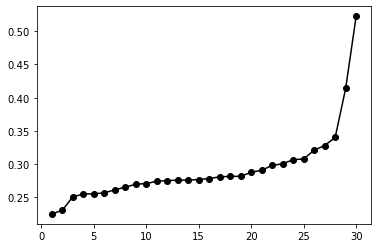

In [299]:
print(np.quantile(res.tolist(), [0,0.25,0.5,0.75,1]))
plt.plot(range(1, len(res)+1), sorted(res.tolist()), '-ok')

In [300]:
# df of DMSO vs VHL for each condition
d=pd.DataFrame(data=r.values(), index=r.keys(), columns=['ERCC pseudo-counts','var'])
d['Experiments']=d.index
d

,ERCC pseudo-counts,var,Experiments
DMSO,0.311663,0.058828,DMSO
Naphthol,0.306745,0.020091,Naphthol
Plumbagin,0.278925,0.011808,Plumbagin
Celastrol,0.273845,0.012862,Celastrol
TM1-001,0.313433,0.106622,TM1-001
Tretinoin,0.267819,0.023748,Tretinoin


In [205]:
# add time condition to df
time_cond = [x.split("_")[-1] for x in r.keys()]
d['time'] = time_cond

# add treatment to df
treatment = ["DMSO" if "DMSO" in x else "VHL" for x in r.keys()]
d["treatment"] = treatment

ERCC scaling factors
* VHL vs DMSO should be different
* protein level in VHL < DMSO: more ERCC transcripts in VHL than DMSO (less RNA transcripts)
* scaling factors: VHL > DMSO - ERCC counts/scaling factors in VHL should be higher

v1


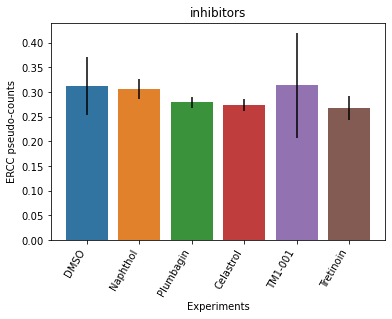

Saved to ../results/slamseq_inhibitors_v1/plots/inhibitors_v1_scaling_fact_with_conf.pdf


In [302]:
version = project.replace("_", " ").split(" ")[-1]
print(version)
createDir(res_dir+"/plots/")

# barplot of DMSO vs VHL for each condition
sns.barplot(x="Experiments", y="ERCC pseudo-counts", data=d, ci=None, )
plt.errorbar(x=range(0,len(d)), y=d['ERCC pseudo-counts'],
             yerr=d['var'], fmt='none', ecolor="black")
plt.xticks(rotation=60, ha='right')
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf", bbox_inches="tight")
plt.show()
print("Saved to "+res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")

__save average ERCC scaling factors__

In [303]:
d

,ERCC pseudo-counts,var,Experiments
DMSO,0.311663,0.058828,DMSO
Naphthol,0.306745,0.020091,Naphthol
Plumbagin,0.278925,0.011808,Plumbagin
Celastrol,0.273845,0.012862,Celastrol
TM1-001,0.313433,0.106622,TM1-001
Tretinoin,0.267819,0.023748,Tretinoin


In [305]:
# save avg ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
d.to_csv(res_dir+project+"_scaling_factors_avg.csv", header=True, index=True)

## Saving the data in our bucket

In [306]:
print(project)

inhibitors_v1


In [307]:
! gsutil -m cp ../../data/slamseq_$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/slamseq_$project/res/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr492-MV411-DMSO-r1_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../data/slamseq_inhibitors_v1/fa

Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr498-MV411-Naphthol-r2_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr498-MV411-Naphthol-r2_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr499-MV411-Naphthol-r3_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr499-MV411-Naphthol-r3_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr499-MV411-Naphthol-r3_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr499-MV411-Naphthol-r3_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr499-MV411-Naphthol-r3_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copyin

Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr511-MV411-Celastrol-r5_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr511-MV411-Celastrol-r5_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr512-MV411-TM1-001-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr512-MV411-TM1-001-r1_R1_001.fastq.gz_trim_galore.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr512-MV411-TM1-001-r1_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr512-MV411-TM1-001-r1_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/fastqs/mr512-MV411-TM1-001-r1_R1_001_val_1.fq.gz [Content-Type=application/octet-stre

Copying file://../../data/slamseq_inhibitors_v1/res/map/mr501-MV411-Naphthol-r5_slamdunk_mapped.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/map/mr503-MV411-Plumbagin-r2_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/map/mr503-MV411-Plumbagin-r2_slamdunk_mapped.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/map/mr504-MV411-Plumbagin-r3_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/map/mr504-MV411-Plumbagin-r3_slamdunk_mapped.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/map/mr505-MV411-Plumbagin-r4_slamdunk_mapped.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/map/mr506-MV411-Plumbagin-r5_slamdunk_mapped.log [Content-Type=application/octet-stre

Copying file://../../data/slamseq_inhibitors_v1/res/filter/ERCC_mr501-MV411-Naphthol-r5_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/ERCC_mr501-MV411-Naphthol-r5_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/ERCC_mr502-MV411-Plumbagin-r1_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/ERCC_mr502-MV411-Plumbagin-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/ERCC_mr505-MV411-Plumbagin-r4_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/ERCC_mr504-MV411-Plumbagin-r3_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/ERCC_mr506-MV411-Plumbagin-r5_filtered.bam [Content-Type=appl

Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr496-MV411-DMSO-r5_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr496-MV411-DMSO-r5_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr496-MV411-DMSO-r5_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr497-MV411-Naphthol-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr497-MV411-Naphthol-r1_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr497-MV411-Naphthol-r1_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr498-MV411-Naphthol-r2_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slams

Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr515-MV411-TM1-001-r4_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr516-MV411-TM1-001-r5_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr516-MV411-TM1-001-r5_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr516-MV411-TM1-001-r5_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr517-MV411-Tretinoin-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr517-MV411-Tretinoin-r1_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/filter/mr517-MV411-Tretinoin-r1_filtered.log [Content-Type=application/octet-stream]...
Copying file://../..

Copying file://../../data/slamseq_inhibitors_v1/res/count/mr502-MV411-Plumbagin-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr503-MV411-Plumbagin-r2_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr503-MV411-Plumbagin-r2_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr503-MV411-Plumbagin-r2_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr503-MV411-Plumbagin-r2_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr504-MV411-Plumbagin-r3_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr504-MV411-Plumbagin-r3_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying f

Copying file://../../data/slamseq_inhibitors_v1/res/count/mr517-MV411-Tretinoin-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr517-MV411-Tretinoin-r1_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr517-MV411-Tretinoin-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr518-MV411-Tretinoin-r2_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr518-MV411-Tretinoin-r2_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr518-MV411-Tretinoin-r2_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v1/res/count/mr518-MV411-Tretinoin-r2_tcount.tsv [Content-Type=text/tab-separated-values]...

# SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

## Make count files

In [308]:
project = project
res_folder = "res"
location = "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_inhibitors_v1/res/count/


In [309]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

<li>readcounts: total counts of every transscript (output of slamdunk algorithm
<li>tccounts: t to c converted RNA transcripts

In [310]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 30 files:dict_keys(['mr492-MV411-DMSO-r1_tcount', 'mr493-MV411-DMSO-r2_tcount', 'mr494-MV411-DMSO-r3_tcount', 'mr495-MV411-DMSO-r4_tcount', 'mr496-MV411-DMSO-r5_tcount', 'mr497-MV411-Naphthol-r1_tcount', 'mr498-MV411-Naphthol-r2_tcount', 'mr499-MV411-Naphthol-r3_tcount', 'mr500-MV411-Naphthol-r4_tcount', 'mr501-MV411-Naphthol-r5_tcount', 'mr502-MV411-Plumbagin-r1_tcount', 'mr503-MV411-Plumbagin-r2_tcount', 'mr504-MV411-Plumbagin-r3_tcount', 'mr505-MV411-Plumbagin-r4_tcount', 'mr506-MV411-Plumbagin-r5_tcount', 'mr507-MV411-Celastrol-r1_tcount', 'mr508-MV411-Celastrol-r2_tcount', 'mr509-MV411-Celastrol-r3_tcount', 'mr510-MV411-Celastrol-r4_tcount', 'mr511-MV411-Celastrol-r5_tcount', 'mr512-MV411-TM1-001-r1_tcount', 'mr513-MV411-TM1-001-r2_tcount', 'mr514-MV411-TM1-001-r3_tcount', 'mr515-MV411-TM1-001-r4_tcount', 'mr516-MV411-TM1-001-r5_tcount', 'mr517-MV411-Tretinoin-r1_tcount', 'mr518-MV411-Tretinoin-r2_tcount', 'mr519-MV411-Tretinoin-r3_tcount', 'mr520-MV411-Tretinoin-r4_tcount',

Check for duplicate gene rows

In [311]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [312]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

if readcounts.shape != tccounts.shape:
    raise ValueError("readcounts and tccounts not the same dimensions: {} | {}".format(readcounts.shape, tccounts.shape))

Duplicate gene rows!
16150 rows | 16113 unique genes
Summing of duplicate gene rows.
Duplicate gene rows!
16150 rows | 16113 unique genes
Summing of duplicate gene rows.


### make density plot

In [313]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
createDir(res_dir)

../results/slamseq_inhibitors_v1/


In [314]:
col = tccounts.columns.tolist() # sort cols
col.sort()
tccounts = tccounts[col]

In [315]:
col = readcounts.columns.tolist() # sort cols
col.sort()
readcounts = readcounts[col]

In [316]:
print(readcounts.shape)
readcounts.iloc[:2]

(16113, 30)


,mr492-MV411-DMSO-r1_tcount,mr493-MV411-DMSO-r2_tcount,mr494-MV411-DMSO-r3_tcount,mr495-MV411-DMSO-r4_tcount,mr496-MV411-DMSO-r5_tcount,mr497-MV411-Naphthol-r1_tcount,mr498-MV411-Naphthol-r2_tcount,mr499-MV411-Naphthol-r3_tcount,mr500-MV411-Naphthol-r4_tcount,mr501-MV411-Naphthol-r5_tcount,...,mr512-MV411-TM1-001-r1_tcount,mr513-MV411-TM1-001-r2_tcount,mr514-MV411-TM1-001-r3_tcount,mr515-MV411-TM1-001-r4_tcount,mr516-MV411-TM1-001-r5_tcount,mr517-MV411-Tretinoin-r1_tcount,mr518-MV411-Tretinoin-r2_tcount,mr519-MV411-Tretinoin-r3_tcount,mr520-MV411-Tretinoin-r4_tcount,mr521-MV411-Tretinoin-r5_tcount
A2M,0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,4,8,2
NAT1,35,47,17,29,19,42,30,37,29,27,...,71,159,69,120,106,85,142,74,366,71


read counts that are t $\rightarrow$ c converted (actively transcribed)
* most at 0 = most are not transcribed
* a lot at 1 or everything at 0 is weird

15320


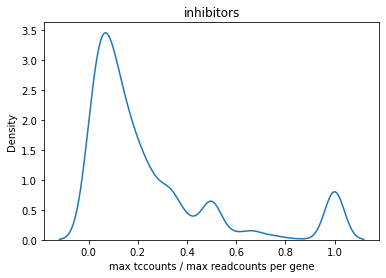

In [317]:
# what is the average of highly transcribed genes
# tccounts/readcounts where sum of readcounts in all samples > 30 
a = tccounts[readcounts.sum(1)>30] / readcounts[readcounts.sum(1)>30]
a = a.fillna(0)
a = a.max(1).tolist() # max val per gene
a.sort()
print(len(a))
sns.kdeplot(a)
plt.xlabel("max tccounts / max readcounts per gene")
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+'plots/'+project+'_tccounts_readcounts_density.pdf', dpi=300, bbox_inches="tight")
plt.show()

In [318]:
np.median(a)

0.14285714285714285

In [319]:
# Save counts to csv
counts_file_prefix = project+'_'+str(minvar_toremove)+'_'+str(mincount_toremove)

readcounts.to_csv(res_dir+counts_file_prefix+"_readcounts.csv",index=True, index_label="GENE")
print("Saved readcounts to: {}".format(res_dir+counts_file_prefix+"_readcounts.csv"))

tccounts.to_csv(res_dir+counts_file_prefix+"_tccounts.csv",index=True, index_label="GENE")
print("Saved tccounts to: {}".format(res_dir+counts_file_prefix+"_tccounts.csv"))

Saved readcounts to: ../results/slamseq_inhibitors_v1/inhibitors_v1_0_5_readcounts.csv
Saved tccounts to: ../results/slamseq_inhibitors_v1/inhibitors_v1_0_5_tccounts.csv


### make more df (mean, median, etc.)

In [320]:
readcounts.iloc[:1]

,mr492-MV411-DMSO-r1_tcount,mr493-MV411-DMSO-r2_tcount,mr494-MV411-DMSO-r3_tcount,mr495-MV411-DMSO-r4_tcount,mr496-MV411-DMSO-r5_tcount,mr497-MV411-Naphthol-r1_tcount,mr498-MV411-Naphthol-r2_tcount,mr499-MV411-Naphthol-r3_tcount,mr500-MV411-Naphthol-r4_tcount,mr501-MV411-Naphthol-r5_tcount,...,mr512-MV411-TM1-001-r1_tcount,mr513-MV411-TM1-001-r2_tcount,mr514-MV411-TM1-001-r3_tcount,mr515-MV411-TM1-001-r4_tcount,mr516-MV411-TM1-001-r5_tcount,mr517-MV411-Tretinoin-r1_tcount,mr518-MV411-Tretinoin-r2_tcount,mr519-MV411-Tretinoin-r3_tcount,mr520-MV411-Tretinoin-r4_tcount,mr521-MV411-Tretinoin-r5_tcount
A2M,0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,4,8,2


In [321]:
print("Genes with highest read counts per sample.")
for column in readcounts:
    print(column.split("MV411-")[1].split("_")[0] +": "+ str(readcounts[column].idxmax()))

Genes with highest read counts per sample.
DMSO-r1: MALAT1
DMSO-r2: RPL13AP5
DMSO-r3: RPL13AP5
DMSO-r4: RPL13AP5
DMSO-r5: RPL13AP5
Naphthol-r1: RPL13AP5
Naphthol-r2: MALAT1
Naphthol-r3: RPL13AP5
Naphthol-r4: RPL13AP5
Naphthol-r5: RPL13AP5
Plumbagin-r1: RPL13AP5
Plumbagin-r2: MALAT1
Plumbagin-r3: RPL13AP5
Plumbagin-r4: RPL13AP5
Plumbagin-r5: RPL13AP5
Celastrol-r1: RPL13AP5
Celastrol-r2: RPL13AP5
Celastrol-r3: RPL13AP5
Celastrol-r4: MALAT1
Celastrol-r5: MALAT1
TM1-001-r1: RPL13AP5
TM1-001-r2: RPL13AP5
TM1-001-r3: MALAT1
TM1-001-r4: MALAT1
TM1-001-r5: RPL13AP5
Tretinoin-r1: RPL13AP5
Tretinoin-r2: RPL13AP5
Tretinoin-r3: RPL13AP5
Tretinoin-r4: RPL13AP5
Tretinoin-r5: RPL13AP5


In [322]:
readcounts.idxmax().value_counts()

RPL13AP5    23
MALAT1       7
dtype: int64

In [325]:
tccounts.columns

Index(['mr492-MV411-DMSO-r1_tcount', 'mr493-MV411-DMSO-r2_tcount',
       'mr494-MV411-DMSO-r3_tcount', 'mr495-MV411-DMSO-r4_tcount',
       'mr496-MV411-DMSO-r5_tcount', 'mr497-MV411-Naphthol-r1_tcount',
       'mr498-MV411-Naphthol-r2_tcount', 'mr499-MV411-Naphthol-r3_tcount',
       'mr500-MV411-Naphthol-r4_tcount', 'mr501-MV411-Naphthol-r5_tcount',
       'mr502-MV411-Plumbagin-r1_tcount', 'mr503-MV411-Plumbagin-r2_tcount',
       'mr504-MV411-Plumbagin-r3_tcount', 'mr505-MV411-Plumbagin-r4_tcount',
       'mr506-MV411-Plumbagin-r5_tcount', 'mr507-MV411-Celastrol-r1_tcount',
       'mr508-MV411-Celastrol-r2_tcount', 'mr509-MV411-Celastrol-r3_tcount',
       'mr510-MV411-Celastrol-r4_tcount', 'mr511-MV411-Celastrol-r5_tcount',
       'mr512-MV411-TM1-001-r1_tcount', 'mr513-MV411-TM1-001-r2_tcount',
       'mr514-MV411-TM1-001-r3_tcount', 'mr515-MV411-TM1-001-r4_tcount',
       'mr516-MV411-TM1-001-r5_tcount', 'mr517-MV411-Tretinoin-r1_tcount',
       'mr518-MV411-Tretinoin-r2_tcount

In [335]:
print(set([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))
print(tccounts.columns[0].split('-', 1))
print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
list(dict.fromkeys([r.split("-", 1)[1].split("_")[0].rsplit("-", 1)[0] for r in tccounts.columns]))

{'MV411-Celastrol', 'MV411-Plumbagin', 'MV411-TM1-001', 'MV411-DMSO', 'MV411-Naphthol', 'MV411-Tretinoin'}
['mr492', 'MV411-DMSO-r1_tcount']
MV411-DMSO


['MV411-DMSO',
 'MV411-Naphthol',
 'MV411-Plumbagin',
 'MV411-Celastrol',
 'MV411-TM1-001',
 'MV411-Tretinoin']

In [334]:
list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))

['MV411-DMSO',
 'MV411-Naphthol',
 'MV411-Plumbagin',
 'MV411-Celastrol',
 'MV411-TM1-001',
 'MV411-Tretinoin']

In [336]:
# get mean counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].mean(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].mean(1)

# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

MV411-DMSO
MV411-Naphthol
MV411-Plumbagin
MV411-Celastrol
MV411-TM1-001
MV411-Tretinoin


In [337]:
# get median counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].median(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].median(1)

# save median counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_median_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_median_readcounts.csv", index=True, index_label="GENE")

MV411-DMSO
MV411-Naphthol
MV411-Plumbagin
MV411-Celastrol
MV411-TM1-001
MV411-Tretinoin


In [339]:
(tccounts/readcounts).fillna(0).iloc[:2]

,mr492-MV411-DMSO-r1_tcount,mr493-MV411-DMSO-r2_tcount,mr494-MV411-DMSO-r3_tcount,mr495-MV411-DMSO-r4_tcount,mr496-MV411-DMSO-r5_tcount,mr497-MV411-Naphthol-r1_tcount,mr498-MV411-Naphthol-r2_tcount,mr499-MV411-Naphthol-r3_tcount,mr500-MV411-Naphthol-r4_tcount,mr501-MV411-Naphthol-r5_tcount,...,mr512-MV411-TM1-001-r1_tcount,mr513-MV411-TM1-001-r2_tcount,mr514-MV411-TM1-001-r3_tcount,mr515-MV411-TM1-001-r4_tcount,mr516-MV411-TM1-001-r5_tcount,mr517-MV411-Tretinoin-r1_tcount,mr518-MV411-Tretinoin-r2_tcount,mr519-MV411-Tretinoin-r3_tcount,mr520-MV411-Tretinoin-r4_tcount,mr521-MV411-Tretinoin-r5_tcount
A2M,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NAT1,0.085714,0.06383,0.117647,0.172414,0.052632,0.119048,0.133333,0.135135,0.241379,0.037037,...,0.070423,0.08805,0.086957,0.133333,0.056604,0.082353,0.176056,0.081081,0.125683,0.098592


In [340]:
# Save tccounts/readcounts file
(tccounts/readcounts).fillna(0).to_csv(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv")
print("Saved tccounts/readcounts to: {}".format(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv"))

Saved tccounts/readcounts to: ../results/slamseq_inhibitors_v1/inhibitors_v1_0_5_tccounts_per_readcounts.csv


## Look at similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [341]:
createDir("../results/slamseq_"+project+"/plots/")

In [343]:
tccounts.columns[:5]

Index(['mr492-MV411-DMSO-r1_tcount', 'mr493-MV411-DMSO-r2_tcount',
       'mr494-MV411-DMSO-r3_tcount', 'mr495-MV411-DMSO-r4_tcount',
       'mr496-MV411-DMSO-r5_tcount'],
      dtype='object')

In [344]:
# conditions
[i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]

['MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-Naphthol',
 'MV411-Naphthol',
 'MV411-Naphthol',
 'MV411-Naphthol',
 'MV411-Naphthol',
 'MV411-Plumbagin',
 'MV411-Plumbagin',
 'MV411-Plumbagin',
 'MV411-Plumbagin',
 'MV411-Plumbagin',
 'MV411-Celastrol',
 'MV411-Celastrol',
 'MV411-Celastrol',
 'MV411-Celastrol',
 'MV411-Celastrol',
 'MV411-TM1-001',
 'MV411-TM1-001',
 'MV411-TM1-001',
 'MV411-TM1-001',
 'MV411-TM1-001',
 'MV411-Tretinoin',
 'MV411-Tretinoin',
 'MV411-Tretinoin',
 'MV411-Tretinoin',
 'MV411-Tretinoin']

### save plots to pdf

In [347]:
tccounts.iloc[:,:10].columns.tolist()

['mr492-MV411-DMSO-r1_tcount',
 'mr493-MV411-DMSO-r2_tcount',
 'mr494-MV411-DMSO-r3_tcount',
 'mr495-MV411-DMSO-r4_tcount',
 'mr496-MV411-DMSO-r5_tcount',
 'mr497-MV411-Naphthol-r1_tcount',
 'mr498-MV411-Naphthol-r2_tcount',
 'mr499-MV411-Naphthol-r3_tcount',
 'mr500-MV411-Naphthol-r4_tcount',
 'mr501-MV411-Naphthol-r5_tcount']

In [351]:
# conditions w/ rep label
[i.split('-', 1)[-1].split("_tc")[0] for i in tccounts.columns]

['MV411-DMSO-r1',
 'MV411-DMSO-r2',
 'MV411-DMSO-r3',
 'MV411-DMSO-r4',
 'MV411-DMSO-r5',
 'MV411-Naphthol-r1',
 'MV411-Naphthol-r2',
 'MV411-Naphthol-r3',
 'MV411-Naphthol-r4',
 'MV411-Naphthol-r5',
 'MV411-Plumbagin-r1',
 'MV411-Plumbagin-r2',
 'MV411-Plumbagin-r3',
 'MV411-Plumbagin-r4',
 'MV411-Plumbagin-r5',
 'MV411-Celastrol-r1',
 'MV411-Celastrol-r2',
 'MV411-Celastrol-r3',
 'MV411-Celastrol-r4',
 'MV411-Celastrol-r5',
 'MV411-TM1-001-r1',
 'MV411-TM1-001-r2',
 'MV411-TM1-001-r3',
 'MV411-TM1-001-r4',
 'MV411-TM1-001-r5',
 'MV411-Tretinoin-r1',
 'MV411-Tretinoin-r2',
 'MV411-Tretinoin-r3',
 'MV411-Tretinoin-r4',
 'MV411-Tretinoin-r5']

Replicate similarity plot saved to: ../results/slamseq_inhibitors_v1/plots/inhibitors_v1_similarity_replicates_sorted_tccounts.pdf


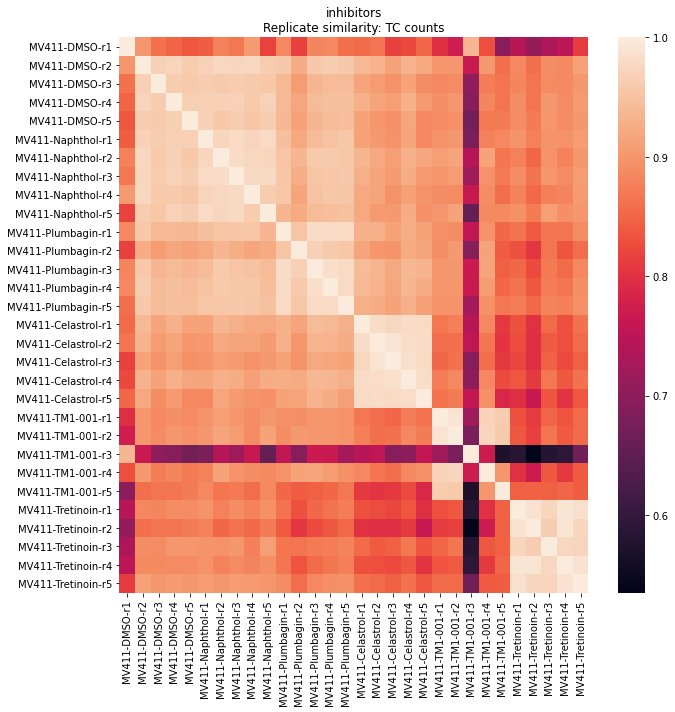

In [360]:
%matplotlib inline
import matplotlib.font_manager

font_settings = {
    "family" : "sans-serif",
    #"sans-serif" : "Arial",
    "size" : 10
}
plt.rc("font", **font_settings)

# tccounts
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(tccounts.corr(), #tccounts.iloc[:,30:50].corr(), 
            # condition w/o rep label
            #xticklabels=[i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns],
            #yticklabels=[i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns],
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].split("_tc")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].split("_tc")[0] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_tccounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_tccounts.pdf'))

Replicate similarity plot saved to: ../results/slamseq_inhibitors_v1/plots/inhibitors_v1_similarity_replicates_sorted_readcounts.pdf


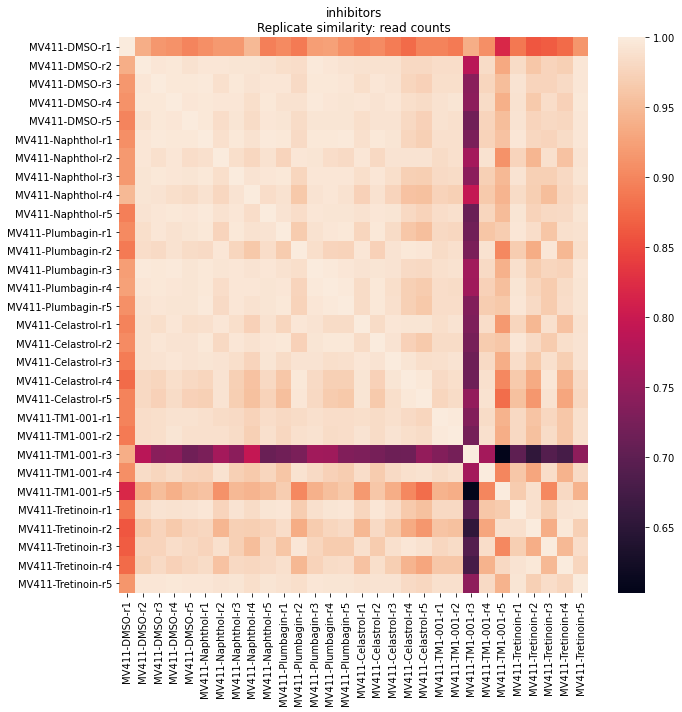

In [359]:
%matplotlib inline

# readcounts
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(readcounts.corr(), 
            # condition w/ replicate
            xticklabels=[i.split('-', 1)[-1].split("_tc")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].split("_tc")[0] for i in tccounts.columns],
            ax=ax)#, cmap=cmp_cylin), vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_readcounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_readcounts.pdf'))

# DESEQ Analysis

In [361]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)

../results/slamseq_inhibitors_v1/


In [363]:
readcounts.iloc[:1]

,mr492-MV411-DMSO-r1_tcount,mr493-MV411-DMSO-r2_tcount,mr494-MV411-DMSO-r3_tcount,mr495-MV411-DMSO-r4_tcount,mr496-MV411-DMSO-r5_tcount,mr497-MV411-Naphthol-r1_tcount,mr498-MV411-Naphthol-r2_tcount,mr499-MV411-Naphthol-r3_tcount,mr500-MV411-Naphthol-r4_tcount,mr501-MV411-Naphthol-r5_tcount,...,mr512-MV411-TM1-001-r1_tcount,mr513-MV411-TM1-001-r2_tcount,mr514-MV411-TM1-001-r3_tcount,mr515-MV411-TM1-001-r4_tcount,mr516-MV411-TM1-001-r5_tcount,mr517-MV411-Tretinoin-r1_tcount,mr518-MV411-Tretinoin-r2_tcount,mr519-MV411-Tretinoin-r3_tcount,mr520-MV411-Tretinoin-r4_tcount,mr521-MV411-Tretinoin-r5_tcount
A2M,0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,4,8,2


In [364]:
# make genes col
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)

tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [365]:
readcounts.iloc[:1]

,mr492-MV411-DMSO-r1_tcount,mr493-MV411-DMSO-r2_tcount,mr494-MV411-DMSO-r3_tcount,mr495-MV411-DMSO-r4_tcount,mr496-MV411-DMSO-r5_tcount,mr497-MV411-Naphthol-r1_tcount,mr498-MV411-Naphthol-r2_tcount,mr499-MV411-Naphthol-r3_tcount,mr500-MV411-Naphthol-r4_tcount,mr501-MV411-Naphthol-r5_tcount,...,mr513-MV411-TM1-001-r2_tcount,mr514-MV411-TM1-001-r3_tcount,mr515-MV411-TM1-001-r4_tcount,mr516-MV411-TM1-001-r5_tcount,mr517-MV411-Tretinoin-r1_tcount,mr518-MV411-Tretinoin-r2_tcount,mr519-MV411-Tretinoin-r3_tcount,mr520-MV411-Tretinoin-r4_tcount,mr521-MV411-Tretinoin-r5_tcount,genes
0,0,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,4,8,2,A2M


In [366]:
tccounts.iloc[:1]

,mr492-MV411-DMSO-r1_tcount,mr493-MV411-DMSO-r2_tcount,mr494-MV411-DMSO-r3_tcount,mr495-MV411-DMSO-r4_tcount,mr496-MV411-DMSO-r5_tcount,mr497-MV411-Naphthol-r1_tcount,mr498-MV411-Naphthol-r2_tcount,mr499-MV411-Naphthol-r3_tcount,mr500-MV411-Naphthol-r4_tcount,mr501-MV411-Naphthol-r5_tcount,...,mr513-MV411-TM1-001-r2_tcount,mr514-MV411-TM1-001-r3_tcount,mr515-MV411-TM1-001-r4_tcount,mr516-MV411-TM1-001-r5_tcount,mr517-MV411-Tretinoin-r1_tcount,mr518-MV411-Tretinoin-r2_tcount,mr519-MV411-Tretinoin-r3_tcount,mr520-MV411-Tretinoin-r4_tcount,mr521-MV411-Tretinoin-r5_tcount,genes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A2M


In [367]:
[i.split('-', 1)[-1].split("_tc")[0] for i in tccounts.columns]

['MV411-DMSO-r1',
 'MV411-DMSO-r2',
 'MV411-DMSO-r3',
 'MV411-DMSO-r4',
 'MV411-DMSO-r5',
 'MV411-Naphthol-r1',
 'MV411-Naphthol-r2',
 'MV411-Naphthol-r3',
 'MV411-Naphthol-r4',
 'MV411-Naphthol-r5',
 'MV411-Plumbagin-r1',
 'MV411-Plumbagin-r2',
 'MV411-Plumbagin-r3',
 'MV411-Plumbagin-r4',
 'MV411-Plumbagin-r5',
 'MV411-Celastrol-r1',
 'MV411-Celastrol-r2',
 'MV411-Celastrol-r3',
 'MV411-Celastrol-r4',
 'MV411-Celastrol-r5',
 'MV411-TM1-001-r1',
 'MV411-TM1-001-r2',
 'MV411-TM1-001-r3',
 'MV411-TM1-001-r4',
 'MV411-TM1-001-r5',
 'MV411-Tretinoin-r1',
 'MV411-Tretinoin-r2',
 'MV411-Tretinoin-r3',
 'MV411-Tretinoin-r4',
 'MV411-Tretinoin-r5',
 'genes']

__Exclude replicates__
* DMSO rep 1
* TM1-001 rep 3

In [368]:
drop_samples = ["DMSO-r1", "TM1-001-r3"]

In [392]:
# col info
cols = tccounts.columns[:-1]
experiments = [x.split("-", 1)[1].rsplit("-", 1)[0] for x in cols]
conds = [x.split("-", 2)[-1].rsplit("-", 1)[0] for x in cols]
time = ["1h" for x in conds]
treatment = [x.split("_")[0] for x in conds]
rep = [x.split("_")[-2].split("-")[-1] for x in cols]
drop = [True if any(sample in x for sample in drop_samples) else False for x in cols]

# experimental design
exp_design = pd.DataFrame(list(zip(cols, experiments, conds, time, treatment, rep, drop)), 
                          columns=["col", "experiment", "cond", "time", "treatment", "rep", "drop"])

In [399]:
exp_design.iloc[4:6]

,col,experiment,cond,time,treatment,rep,drop
4,mr496-MV411-DMSO-r5_tcount,MV411-DMSO,DMSO,1h,DMSO,r5,False
5,mr497-MV411-Naphthol-r1_tcount,MV411-Naphthol,Naphthol,1h,Naphthol,r1,False


## Naphthol

### make design matrix

In [427]:
# DMSO vs Napthol
version = "v1"
var_name = "treatment"
var1 = "DMSO"
var2 = "Naphthol"
drop_rep = exp_design.loc[(exp_design[var_name] == var2) & (exp_design["drop"] == True), "col"]

In [402]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [444]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var1) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx]["treatment"] == var2) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var_cols = [x+y for x,y in zip(var1_cols, var2_cols)]

In [430]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [432]:
design.head()

,DMSO,Naphthol
mr492.MV411.DMSO.r1_tcount,False,False
mr493.MV411.DMSO.r2_tcount,True,False
mr494.MV411.DMSO.r3_tcount,True,False
mr495.MV411.DMSO.r4_tcount,True,False
mr496.MV411.DMSO.r5_tcount,True,False


In [433]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [434]:
scaling="ERCCsamplewise"

#### make DESeq object

In [447]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [448]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [492]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [493]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr493-MV411-DMSO-r2_filtered.bam         0.340240
ERCC_mr494-MV411-DMSO-r3_filtered.bam         0.281739
ERCC_mr495-MV411-DMSO-r4_filtered.bam         0.256905
ERCC_mr496-MV411-DMSO-r5_filtered.bam         0.265488
ERCC_mr502-MV411-Plumbagin-r1_filtered.bam    0.298296
ERCC_mr503-MV411-Plumbagin-r2_filtered.bam    0.275357
ERCC_mr504-MV411-Plumbagin-r3_filtered.bam    0.281014
ERCC_mr505-MV411-Plumbagin-r4_filtered.bam    0.278486
ERCC_mr506-MV411-Plumbagin-r5_filtered.bam    0.261471
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [494]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [453]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [454]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.59 s, sys: 396 ms, total: 6.99 s
Wall time: 6.71 s


In [455]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.85 s, sys: 1.81 s, total: 9.66 s
Wall time: 6.12 s


#### save DESeq results

In [456]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [462]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_Naphthol_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [464]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Naphthol_ERCCsamplewise_0_5_deseq_tccounts.csv


In [465]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Naphthol_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [468]:
scaling = None

#### make DESeq object

In [469]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [470]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [471]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [474]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 5.88 s, sys: 360 ms, total: 6.24 s
Wall time: 5.45 s


In [473]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.57 s, sys: 1.69 s, total: 9.26 s
Wall time: 5.69 s


In [475]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,3.614001,0.086148,0.654598,-0.131604,0.895297,NaN,NAT1,NAT1
2,2.661846,-0.441500,0.768835,0.574245,0.565802,NaN,AAMP,AAMP
3,5.203761,0.612632,0.539552,-1.135446,0.256189,NaN,AARS1,AARS1
4,0.608462,2.219903,1.874822,-1.184061,0.236389,NaN,ABAT,ABAT


In [476]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.175901,-0.606984,2.735825,0.221865,0.824419,NaN,A2M,A2M
1,29.512012,-0.155357,0.247179,0.628522,0.529662,0.999947,NAT1,NAT1
2,96.715260,-0.060401,0.147499,0.409500,0.682173,0.999947,AAMP,AAMP
3,121.817282,0.049043,0.136957,-0.358092,0.720274,0.999947,AARS1,AARS1
4,16.221585,0.490224,0.347961,-1.408847,0.158880,0.999947,ABAT,ABAT


#### save DESeq results

In [477]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [478]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_Naphthol_0_5_deseq_tccounts.csv'

In [479]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Naphthol_0_5_deseq_tccounts.csv


In [480]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Naphthol_0_5_deseq_readcounts.csv


## Plumbagin

### make design matrix

In [481]:
# DMSO vs Plumbagin
version = "v1"
var_name = "treatment"
var1 = "DMSO"
var2 = "Plumbagin"
drop_rep = exp_design.loc[(exp_design[var_name] == var2) & (exp_design["drop"] == True), "col"]

In [482]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [483]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var1) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx]["treatment"] == var2) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var_cols = [x+y for x,y in zip(var1_cols, var2_cols)]

In [484]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [487]:
design[design.isin([True]).any(axis=1)]

,DMSO,Plumbagin
mr493.MV411.DMSO.r2_tcount,True,False
mr494.MV411.DMSO.r3_tcount,True,False
mr495.MV411.DMSO.r4_tcount,True,False
mr496.MV411.DMSO.r5_tcount,True,False
mr502.MV411.Plumbagin.r1_tcount,False,True
mr503.MV411.Plumbagin.r2_tcount,False,True
mr504.MV411.Plumbagin.r3_tcount,False,True
mr505.MV411.Plumbagin.r4_tcount,False,True
mr506.MV411.Plumbagin.r5_tcount,False,True


In [488]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [489]:
scaling="ERCCsamplewise"

#### make DESeq object

In [495]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [496]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [497]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [498]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr493-MV411-DMSO-r2_filtered.bam         0.340240
ERCC_mr494-MV411-DMSO-r3_filtered.bam         0.281739
ERCC_mr495-MV411-DMSO-r4_filtered.bam         0.256905
ERCC_mr496-MV411-DMSO-r5_filtered.bam         0.265488
ERCC_mr502-MV411-Plumbagin-r1_filtered.bam    0.298296
ERCC_mr503-MV411-Plumbagin-r2_filtered.bam    0.275357
ERCC_mr504-MV411-Plumbagin-r3_filtered.bam    0.281014
ERCC_mr505-MV411-Plumbagin-r4_filtered.bam    0.278486
ERCC_mr506-MV411-Plumbagin-r5_filtered.bam    0.261471
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [499]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [500]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [501]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 5.82 s, sys: 388 ms, total: 6.21 s
Wall time: 5.43 s


In [502]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.58 s, sys: 1.84 s, total: 9.41 s
Wall time: 5.57 s


#### save DESeq results

In [503]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [504]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_Plumbagin_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [505]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Plumbagin_ERCCsamplewise_0_5_deseq_tccounts.csv


In [506]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Plumbagin_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [508]:
scaling = None

#### make DESeq object

In [509]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [510]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [511]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [512]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 5.9 s, sys: 368 ms, total: 6.27 s
Wall time: 5.49 s


In [513]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.24 s, sys: 1.89 s, total: 10.1 s
Wall time: 6.3 s


In [514]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,2.401497,-0.686391,0.776225,0.884269,0.376551,NaN,NAT1,NAT1
2,3.017694,0.217853,0.713305,-0.305414,0.760051,NaN,AAMP,AAMP
3,4.646912,0.680216,0.568047,-1.197464,0.231126,NaN,AARS1,AARS1
4,0.704122,2.496781,1.777933,-1.404317,0.160225,NaN,ABAT,ABAT


In [515]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.146508,-0.481692,2.858617,0.168505,0.866186,NaN,A2M,A2M
1,27.440840,-0.224708,0.269701,0.833174,0.404747,0.999543,NAT1,NAT1
2,95.274605,0.038631,0.157089,-0.245918,0.805745,0.999543,AAMP,AAMP
3,115.632250,0.060340,0.146282,-0.412492,0.679979,0.999543,AARS1,AARS1
4,14.219219,0.256942,0.360709,-0.712327,0.476263,NaN,ABAT,ABAT


#### save DESeq results

In [516]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [517]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_Plumbagin_0_5_deseq_tccounts.csv'

In [518]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Plumbagin_0_5_deseq_tccounts.csv


In [519]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Plumbagin_0_5_deseq_readcounts.csv


## Celastrol

### make design matrix

In [522]:
# DMSO vs Celastrol
version = "v1"
var_name = "treatment"
var1 = "DMSO"
var2 = "Celastrol"
drop_rep = exp_design.loc[(exp_design[var_name] == var2) & (exp_design["drop"] == True), "col"]

In [523]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [524]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var1) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx]["treatment"] == var2) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var_cols = [x+y for x,y in zip(var1_cols, var2_cols)]

In [525]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [526]:
design[design.isin([True]).any(axis=1)]

,DMSO,Celastrol
mr493.MV411.DMSO.r2_tcount,True,False
mr494.MV411.DMSO.r3_tcount,True,False
mr495.MV411.DMSO.r4_tcount,True,False
mr496.MV411.DMSO.r5_tcount,True,False
mr507.MV411.Celastrol.r1_tcount,False,True
mr508.MV411.Celastrol.r2_tcount,False,True
mr509.MV411.Celastrol.r3_tcount,False,True
mr510.MV411.Celastrol.r4_tcount,False,True
mr511.MV411.Celastrol.r5_tcount,False,True


In [527]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [528]:
scaling="ERCCsamplewise"

#### make DESeq object

In [529]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [530]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [531]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [532]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr493-MV411-DMSO-r2_filtered.bam         0.340240
ERCC_mr494-MV411-DMSO-r3_filtered.bam         0.281739
ERCC_mr495-MV411-DMSO-r4_filtered.bam         0.256905
ERCC_mr496-MV411-DMSO-r5_filtered.bam         0.265488
ERCC_mr507-MV411-Celastrol-r1_filtered.bam    0.276965
ERCC_mr508-MV411-Celastrol-r2_filtered.bam    0.274393
ERCC_mr509-MV411-Celastrol-r3_filtered.bam    0.290863
ERCC_mr510-MV411-Celastrol-r4_filtered.bam    0.250981
ERCC_mr511-MV411-Celastrol-r5_filtered.bam    0.276022
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [533]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [534]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [535]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.29 s, sys: 360 ms, total: 6.65 s
Wall time: 5.87 s


In [536]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.66 s, sys: 1.66 s, total: 9.31 s
Wall time: 5.66 s


In [537]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,5.531574,0.259526,0.601327,-0.431589,0.666040,NaN,NAT1,NAT1
2,4.071881,-0.191994,0.707274,0.271456,0.786040,NaN,AAMP,AAMP
3,13.134364,1.761157,0.471794,-3.732890,0.000189,0.003546,AARS1,AARS1
4,0.485934,1.457512,1.834404,-0.794542,0.426880,NaN,ABAT,ABAT


In [538]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.236486,-0.907960,2.459200,0.369210,0.711972,NaN,A2M,A2M
1,48.663986,0.044700,0.220051,-0.203135,0.839029,0.943389,NAT1,NAT1
2,141.014763,-0.178527,0.149214,1.196449,0.231521,0.554732,AAMP,AAMP
3,191.739699,0.158288,0.130045,-1.217175,0.223538,0.544558,AARS1,AARS1
4,21.832390,0.302793,0.344532,-0.878854,0.379480,NaN,ABAT,ABAT


#### save DESeq results

In [539]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [540]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_Celastrol_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [541]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Celastrol_ERCCsamplewise_0_5_deseq_tccounts.csv


In [542]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Celastrol_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [543]:
scaling = None

#### make DESeq object

In [544]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [545]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [546]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [547]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 5.95 s, sys: 352 ms, total: 6.3 s
Wall time: 5.52 s


In [548]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.35 s, sys: 1.72 s, total: 10.1 s
Wall time: 6.22 s


In [549]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,5.402427,0.198160,0.601592,-0.329393,0.741859,NaN,NAT1,NAT1
2,3.996886,-0.250054,0.708490,0.352940,0.724134,NaN,AAMP,AAMP
3,12.660093,1.696741,0.471587,-3.597937,0.000321,0.00519,AARS1,AARS1
4,0.446006,1.350903,1.856098,-0.727818,0.466725,NaN,ABAT,ABAT


In [550]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.221144,-1.038385,2.528778,0.410627,0.681346,NaN,A2M,A2M
1,47.447845,-0.022362,0.217688,0.102723,0.918183,0.968121,NAT1,NAT1
2,137.907876,-0.241776,0.149569,1.616483,0.105990,0.378921,AAMP,AAMP
3,186.968839,0.094167,0.129625,-0.726456,0.467560,0.748691,AARS1,AARS1
4,21.359987,0.241231,0.349576,-0.690069,0.490151,NaN,ABAT,ABAT


#### save DESeq results

In [551]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [552]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_Celastrol_0_5_deseq_tccounts.csv'

In [553]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Celastrol_0_5_deseq_tccounts.csv


In [554]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Celastrol_0_5_deseq_readcounts.csv


## TM1-001

In [561]:
design.iloc[20:25]

,DMSO,Celastrol
mr512.MV411.TM1.001.r1_tcount,False,False
mr513.MV411.TM1.001.r2_tcount,False,False
mr514.MV411.TM1.001.r3_tcount,False,False
mr515.MV411.TM1.001.r4_tcount,False,False
mr516.MV411.TM1.001.r5_tcount,False,False


### make design matrix

if "-" in var, only use portion of var before or after "-" for variable

In [624]:
# DMSO vs TM1-001 (TM1-001)
version = "v1"
var_name = "treatment"
var1 = "DMSO"
var2 = "TM1"
drop_rep = exp_design.loc[(exp_design[var_name] == var2) & (exp_design["drop"] == True), "col"]

In [625]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [626]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var1) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (var2 in exp_design.iloc[idx]["treatment"]) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var_cols = [x+y for x,y in zip(var1_cols, var2_cols)]

In [627]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [629]:
design[np.array(var_cols, bool)]

,DMSO,TM1
mr493.MV411.DMSO.r2_tcount,True,False
mr494.MV411.DMSO.r3_tcount,True,False
mr495.MV411.DMSO.r4_tcount,True,False
mr496.MV411.DMSO.r5_tcount,True,False
mr512.MV411.TM1.001.r1_tcount,False,True
mr513.MV411.TM1.001.r2_tcount,False,True
mr515.MV411.TM1.001.r4_tcount,False,True
mr516.MV411.TM1.001.r5_tcount,False,True


In [630]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [631]:
scaling="ERCCsamplewise"

#### make DESeq object

In [632]:
"~{} - {}".format(var1, var2)

'~DMSO - TM1'

In [633]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [634]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [635]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [636]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr493-MV411-DMSO-r2_filtered.bam       0.340240
ERCC_mr494-MV411-DMSO-r3_filtered.bam       0.281739
ERCC_mr495-MV411-DMSO-r4_filtered.bam       0.256905
ERCC_mr496-MV411-DMSO-r5_filtered.bam       0.265488
ERCC_mr512-MV411-TM1-001-r1_filtered.bam    0.255481
ERCC_mr513-MV411-TM1-001-r2_filtered.bam    0.276141
ERCC_mr515-MV411-TM1-001-r4_filtered.bam    0.287868
ERCC_mr516-MV411-TM1-001-r5_filtered.bam    0.225275
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [637]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [638]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [639]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.74 s, sys: 912 ms, total: 7.65 s
Wall time: 5.82 s


In [640]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.48 s, sys: 932 ms, total: 7.42 s
Wall time: 5.36 s


#### save DESeq results

if "-" in var, manually add dropped portion of original var to file name

In [641]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [643]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2+"-001", scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_TM1-001_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [644]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2+"-001", scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_TM1-001_ERCCsamplewise_0_5_deseq_tccounts.csv


In [645]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2+"-001", scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_TM1-001_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [646]:
scaling = None

#### make DESeq object

In [647]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [648]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [649]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [650]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.34 s, sys: 864 ms, total: 7.21 s
Wall time: 5.38 s


In [651]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.88 s, sys: 824 ms, total: 7.71 s
Wall time: 5.91 s


In [652]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,5.875469,0.066462,0.785059,-0.084659,0.932533,0.977843,NAT1,NAT1
2,4.387628,-0.376999,0.742741,0.507577,0.611750,0.850445,AAMP,AAMP
3,18.021696,2.214279,0.515591,-4.294642,0.000017,0.000580,AARS1,AARS1
4,0.617939,1.741536,1.841432,-0.945751,0.344276,NaN,ABAT,ABAT


In [653]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.207144,-2.231582,3.047073,0.732369,0.463943,NaN,A2M,A2M
1,56.108677,-0.138436,0.369332,0.374828,0.707789,0.953810,NAT1,NAT1
2,167.975431,-0.283812,0.176552,1.607527,0.107939,0.578331,AAMP,AAMP
3,245.987613,0.280024,0.194072,-1.442888,0.149052,0.649522,AARS1,AARS1
4,29.213516,0.451481,0.347580,-1.298927,0.193969,0.702320,ABAT,ABAT


#### save DESeq results

In [654]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [655]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2+"-001", scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_TM1-001_0_5_deseq_tccounts.csv'

In [656]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2+"-001", scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_TM1-001_0_5_deseq_tccounts.csv


In [657]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2+"-001", scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_TM1-001_0_5_deseq_readcounts.csv


## Tretinoin

### make design matrix

In [658]:
# DMSO vs Tretinoin
version = "v1"
var_name = "treatment"
var1 = "DMSO"
var2 = "Tretinoin"
drop_rep = exp_design.loc[(exp_design[var_name] == var2) & (exp_design["drop"] == True), "col"]

In [659]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [660]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var1) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx]["treatment"] == var2) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var_cols = [x+y for x,y in zip(var1_cols, var2_cols)]

In [661]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [662]:
design[design.isin([True]).any(axis=1)]

,DMSO,Tretinoin
mr493.MV411.DMSO.r2_tcount,True,False
mr494.MV411.DMSO.r3_tcount,True,False
mr495.MV411.DMSO.r4_tcount,True,False
mr496.MV411.DMSO.r5_tcount,True,False
mr517.MV411.Tretinoin.r1_tcount,False,True
mr518.MV411.Tretinoin.r2_tcount,False,True
mr519.MV411.Tretinoin.r3_tcount,False,True
mr520.MV411.Tretinoin.r4_tcount,False,True
mr521.MV411.Tretinoin.r5_tcount,False,True


In [663]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [664]:
scaling="ERCCsamplewise"

#### make DESeq object

In [665]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [666]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [667]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [668]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr493-MV411-DMSO-r2_filtered.bam         0.340240
ERCC_mr494-MV411-DMSO-r3_filtered.bam         0.281739
ERCC_mr495-MV411-DMSO-r4_filtered.bam         0.256905
ERCC_mr496-MV411-DMSO-r5_filtered.bam         0.265488
ERCC_mr517-MV411-Tretinoin-r1_filtered.bam    0.270812
ERCC_mr518-MV411-Tretinoin-r2_filtered.bam    0.230661
ERCC_mr519-MV411-Tretinoin-r3_filtered.bam    0.255199
ERCC_mr520-MV411-Tretinoin-r4_filtered.bam    0.300603
ERCC_mr521-MV411-Tretinoin-r5_filtered.bam    0.281819
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [669]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [670]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [671]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.01 s, sys: 836 ms, total: 7.84 s
Wall time: 5.93 s


In [672]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.84 s, sys: 1.77 s, total: 9.61 s
Wall time: 5.99 s


In [673]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,6.768743,-0.200158,0.576409,0.347250,0.728404,0.895575,NAT1,NAT1
2,6.656204,-0.002874,0.605391,0.004747,0.996213,0.998655,AAMP,AAMP
3,13.402547,1.023759,0.497636,-2.057244,0.039663,0.204758,AARS1,AARS1
4,1.374642,2.256584,1.295636,-1.741680,0.081564,NaN,ABAT,ABAT


In [674]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.912257,0.562397,1.594131,-0.352792,0.724244,NaN,A2M,A2M
1,63.557583,-0.356058,0.243727,1.460892,0.144045,0.759130,NAT1,NAT1
2,227.879186,0.023081,0.159323,-0.144869,0.884814,0.996172,AAMP,AAMP
3,290.343420,0.168798,0.170724,-0.988716,0.322802,0.873200,AARS1,AARS1
4,39.355014,0.640676,0.301689,-2.123630,0.033701,0.442075,ABAT,ABAT


#### save DESeq results

In [675]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [676]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_Tretinoin_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [677]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Tretinoin_ERCCsamplewise_0_5_deseq_tccounts.csv


In [678]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Tretinoin_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [679]:
scaling = None

#### make DESeq object

In [680]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [681]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [682]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [683]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.57 s, sys: 816 ms, total: 7.39 s
Wall time: 5.55 s


In [684]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.71 s, sys: 1.72 s, total: 9.43 s
Wall time: 5.71 s


In [685]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,6.524734,-0.295706,0.570508,0.518321,0.604235,0.848824,NAT1,NAT1
2,6.435022,-0.088202,0.607806,0.145115,0.884620,0.967578,AAMP,AAMP
3,12.644458,0.905353,0.481334,-1.880924,0.059982,0.286805,AARS1,AARS1
4,1.244083,2.115603,1.286812,-1.644065,0.100163,NaN,ABAT,ABAT


In [686]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.865655,0.496835,1.637740,-0.303366,0.761611,NaN,A2M,A2M
1,61.480877,-0.450604,0.242288,1.859788,0.062915,0.585229,NAT1,NAT1
2,219.435451,-0.076200,0.146354,0.520657,0.602606,0.972426,AAMP,AAMP
3,278.079657,0.061580,0.147296,-0.418068,0.675897,0.977016,AARS1,AARS1
4,37.470073,0.550399,0.274097,-2.008040,0.044639,0.505688,ABAT,ABAT


#### save DESeq results

In [687]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [688]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v1_DMSO_Tretinoin_0_5_deseq_tccounts.csv'

In [689]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Tretinoin_0_5_deseq_tccounts.csv


In [690]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v1_DMSO_Tretinoin_0_5_deseq_readcounts.csv


# PLOTS

## whisker's plots

### Get CRCs

In [835]:
crc = pd.read_csv('../data/CRCs.txt',header=None)[0].values.tolist()
print(len(crc))
print(crc)

31
['CEBPA', 'E2F3', 'FLI1', 'FOSL2', 'GFI1', 'HEX', 'IRF8', 'LYL1', 'MEF2C', 'MEF2D', 'MEIS1', 'MYB', 'PLAGL2', 'RUNX1', 'RUNX2', 'RXRA', 'SP1', 'SPI1', 'SREBF1', 'STAT5B', 'TFAP4', 'ZEB2', 'ZFPM1', 'ZNF281', 'LMO2', 'ZMYND8', 'GATA2', 'MAX', 'MYC', 'ETV6', 'HOXA9']


### MYB 1h (unscaled)

In [949]:
%matplotlib inline

In [950]:
# MYB dTAG 1h
gene = "MYB"
version = "v1"
var_name = "time"
var = "1h"
scaling=None

In [951]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_timecourse_v1_MYB_1h_0_5_deseq'

In [952]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [930]:
#resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-6.885410,0.081930,-16.026083,0.000000,4.169242e-87
0.45,3.297442,-0.000000,0.377294,-0.214276,0.312183,8.143409e-01
0.50,5.453019,0.000000,0.432355,-0.092227,0.381684,8.435402e-01
0.75,33.586157,0.275681,1.141081,0.581614,0.722900,9.395009e-01
1.00,4834.938853,3.775585,3.352475,20.244847,0.999503,9.995027e-01


In [931]:
#resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-3.983753,0.076678,-13.142706,0.000000,2.559162e-35
0.45,69.326787,-0.008962,0.191052,-0.277148,0.336871,6.211564e-01
0.50,111.514525,0.032029,0.208633,-0.123315,0.392057,6.518995e-01
0.75,650.883340,0.236780,0.635873,0.729347,0.686658,8.387542e-01
1.00,192666.451207,4.663691,3.352475,12.848621,0.999966,9.999658e-01


In [953]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,4.297009,0.752786,0.450361,-1.671517,0.094620,0.521209,NAT1,NAT1,other
3,4.927907,-0.223276,0.276458,0.807631,0.419303,0.842671,AAMP,AAMP,other
4,5.109371,0.108817,0.288949,-0.376597,0.706473,0.939624,AARS1,AARS1,other
10,6.134381,-0.329921,0.195381,1.688604,0.091295,0.516477,ABCF1,ABCF1,other
11,6.518499,-0.296996,0.187487,1.584088,0.113174,0.560093,ABL1,ABL1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_1h_0_5_whiskers_logfch.pdf


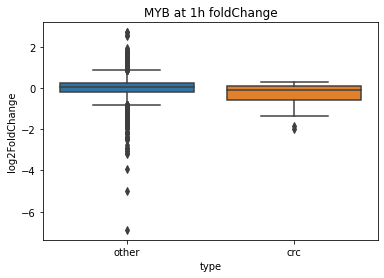

In [954]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{} at {} foldChange".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_1h_0_5_whiskers_baseMean.pdf


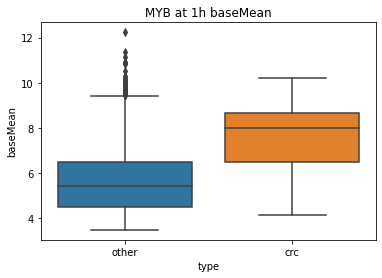

In [955]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{} at {} baseMean".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

### MYB 2h (unscaled)

In [956]:
%matplotlib inline

In [957]:
# MYB dTAG 2h
gene = "MYB"
version = "v1"
var_name = "time"
var = "2h"
scaling = None

In [958]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_timecourse_v1_MYB_2h_0_5_deseq'

In [959]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [960]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-7.839439,0.056167,-19.909083,0.000000,1.127083e-92
0.45,5.299296,-0.000000,0.290908,-0.224087,0.256408,6.747991e-01
0.50,8.781921,0.000000,0.329911,-0.095603,0.331980,7.188177e-01
0.75,56.026930,0.279917,0.905071,0.686466,0.691653,8.869381e-01
1.00,8275.895513,4.618558,3.160747,20.869330,0.999712,9.997123e-01


In [961]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-3.237344,0.041529,-20.756989,0.000000,1.510003e-91
0.45,75.410636,-0.002800,0.182535,-0.261008,0.400753,8.786791e-01
0.50,119.690443,0.025952,0.202048,-0.127808,0.453781,9.002336e-01
0.75,722.613135,0.258950,0.606672,0.618913,0.724977,9.647281e-01
1.00,229179.596093,4.912589,3.160747,20.541718,0.999818,9.998177e-01


In [962]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,5.529516,0.273015,0.313194,-0.871711,0.383366,0.735587,NAT1,NAT1,other
3,5.522865,-0.624456,0.290171,2.152025,0.031395,0.188833,AAMP,AAMP,other
4,6.141175,0.505409,0.166225,-3.040510,0.002362,0.027596,AARS1,AARS1,other
10,6.557188,-0.349387,0.239186,1.460732,0.144089,0.472211,ABCF1,ABCF1,other
11,6.732463,-0.097869,0.169552,0.577221,0.563790,0.844917,ABL1,ABL1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_2h_0_5_whiskers_logfch.pdf


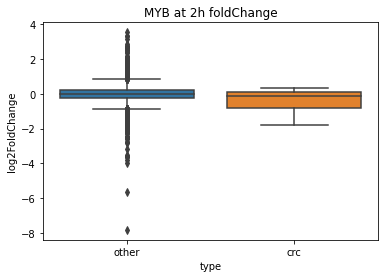

In [963]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{} at {} foldChange".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_2h_0_5_whiskers_baseMean.pdf


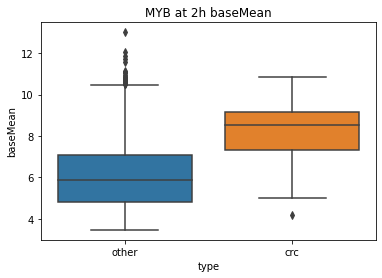

In [964]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{} at {} baseMean".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

### MYB 4h (unscaled)

In [965]:
%matplotlib inline

In [966]:
# MYB dTAG 4h
gene = "MYB"
version = "v1"
var_name = "time"
var = "4h"
scaling=None

In [967]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_timecourse_v1_MYB_4h_0_5_deseq'

In [968]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [969]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-6.948540,0.073944,-14.563087,0.000000,4.209658e-109
0.45,3.022219,-0.000000,0.371652,-0.163562,0.130603,3.456167e-01
0.50,4.914857,0.000000,0.425978,-0.000549,0.208024,4.258013e-01
0.75,29.926014,0.332335,1.142716,0.896255,0.643059,7.514567e-01
1.00,3982.391427,4.635158,3.160747,22.603521,0.999962,9.996459e-01


In [970]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-4.574308,0.065563,-22.456107,0.000000,1.518883e-154
0.45,58.294527,-0.020091,0.178955,-0.303537,0.196753,2.776457e-01
0.50,91.689555,0.024864,0.200440,-0.112962,0.261255,3.419048e-01
0.75,573.100456,0.376745,0.647419,1.005999,0.624327,7.011808e-01
1.00,177875.429281,4.948241,3.160747,26.842265,0.999941,9.998303e-01


In [971]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,4.745327,0.639648,0.350121,-1.826935,0.067710,0.203726,NAT1,NAT1,other
3,4.452812,-0.683553,0.322731,2.118027,0.034173,0.127981,AAMP,AAMP,other
4,4.993221,0.252953,0.254973,-0.992078,0.321159,0.541330,AARS1,AARS1,other
5,3.648908,0.266582,0.373440,-0.713854,0.475317,0.681857,ABAT,ABAT,other
10,5.446691,-0.870906,0.242488,3.591542,0.000329,0.004021,ABCF1,ABCF1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_4h_0_5_whiskers_logfch.pdf


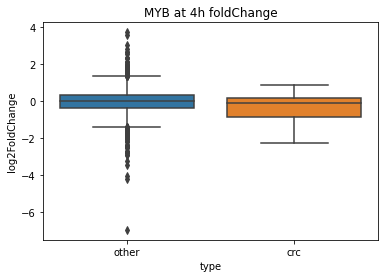

In [972]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{} at {} foldChange".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_4h_0_5_whiskers_baseMean.pdf


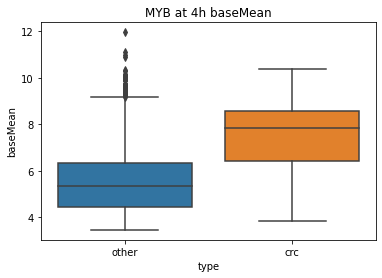

In [973]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{} at {} baseMean".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

### MYB 8h (unscaled)

In [836]:
%matplotlib inline

In [974]:
# MYB dTAG 8h
gene = "MYB"
version = "v1"
var_name = "time"
var = "8h"
scaling=None

In [975]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_timecourse_v1_MYB_8h_0_5_deseq'

In [976]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [977]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-9.072170,0.052768,-29.123296,0.000000,2.201063e-182
0.45,3.560394,-0.000000,0.310552,-0.058651,0.158568,4.732954e-01
0.50,5.882089,0.000000,0.355885,0.115601,0.234419,5.466467e-01
0.75,35.558121,0.185380,1.008240,1.021185,0.660866,8.261279e-01
1.00,4511.019186,4.780008,3.160747,22.240809,0.999901,9.999014e-01


In [978]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-6.296404,0.035502,-35.614750,0.000000,1.290958e-273
0.45,56.202038,-0.056124,0.146093,-0.149075,0.151578,2.235145e-01
0.50,88.885436,-0.004453,0.163416,0.064525,0.211801,3.024848e-01
0.75,516.761658,0.288861,0.573788,1.264412,0.599344,6.909240e-01
1.00,157352.746485,5.502280,3.160747,26.893456,0.999986,9.999865e-01


In [979]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,4.912818,-0.171072,0.230137,0.743347,0.457271,0.716301,NAT1,NAT1,other
3,4.709480,0.093770,0.241316,-0.388579,0.697588,0.870393,AAMP,AAMP,other
4,5.259467,-0.257605,0.216248,1.191250,0.233555,0.500210,AARS1,AARS1,other
5,3.532139,0.278657,0.381462,-0.730497,0.465087,0.722329,ABAT,ABAT,other
10,6.004455,-0.404354,0.162984,2.480938,0.013104,0.071685,ABCF1,ABCF1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_8h_0_5_whiskers_logfch.pdf


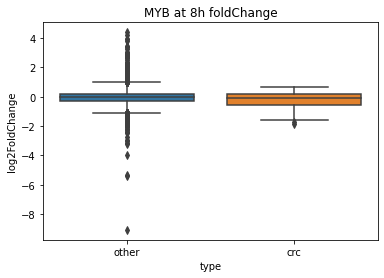

In [980]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{} at {} foldChange".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_8h_0_5_whiskers_baseMean.pdf


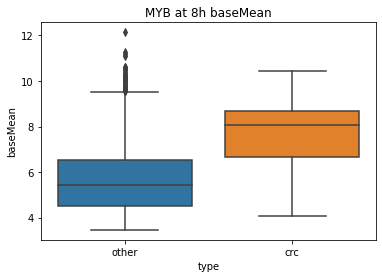

In [981]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{} at {} baseMean".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

### MYB 12h (unscaled)

In [982]:
%matplotlib inline

In [983]:
# MYB dTAG 12h
gene = "MYB"
version = "v1"
var_name = "time"
var = "12h"
scaling=None

In [984]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_timecourse_v1_MYB_12h_0_5_deseq'

In [985]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [986]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-8.711061,0.085891,-22.616491,0.000000,3.017403e-109
0.45,2.460794,-0.000000,0.418866,-0.033091,0.174787,4.671572e-01
0.50,4.023927,0.000000,0.475528,0.041018,0.246864,5.312608e-01
0.75,23.378027,0.243132,1.202699,0.859942,0.669571,8.083665e-01
1.00,3707.740219,6.742002,3.352471,11.897725,0.999732,9.994479e-01


In [987]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-5.906845,0.063576,-38.237953,0.000000,0.000000
0.45,50.292179,-0.065613,0.199408,-0.129995,0.209482,0.304185
0.50,81.091291,-0.008972,0.225112,0.043310,0.274848,0.383754
0.75,467.508578,0.335288,0.761775,1.100514,0.639360,0.736713
1.00,146137.359163,6.301837,3.352471,39.540943,0.999832,0.999832


In [988]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,4.235762,0.170673,0.326487,-0.522754,0.601145,0.804602,NAT1,NAT1,other
3,4.353861,-1.236768,0.353986,3.493828,0.000476,0.006852,AAMP,AAMP,other
4,4.661307,-0.126294,0.300160,0.420756,0.673933,0.845716,AARS1,AARS1,other
10,5.351592,-0.176688,0.254105,0.695335,0.486846,0.731552,ABCF1,ABCF1,other
11,5.174917,-0.192052,0.267580,0.717737,0.472919,0.721032,ABL1,ABL1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_12h_0_5_whiskers_logfch.pdf


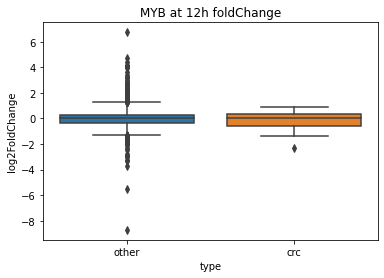

In [989]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{} at {} foldChange".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_12h_0_5_whiskers_baseMean.pdf


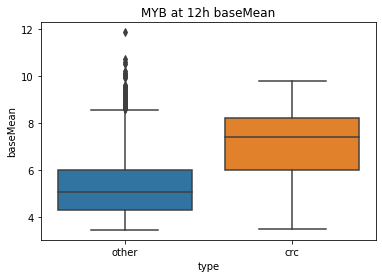

In [990]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{} at {} baseMean".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

### MYB 24h (ERCC normalized)

In [836]:
%matplotlib inline

In [991]:
# MYB dTAG 24h
gene = "MYB"
version = "v1"
var_name = "time"
var = "24h"
scaling="ERCCsamplewise"

In [992]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_timecourse_v1_MYB_24h_ERCCsamplewise_0_5_deseq'

In [993]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [994]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-9.343938,0.086949,-23.915035,0.000000,3.912144e-135
0.45,4.823387,-0.261398,0.304962,0.494721,0.065690,2.096015e-01
0.50,7.664118,-0.222022,0.348457,0.722086,0.121572,2.791842e-01
0.75,43.608181,0.000000,0.981763,2.077949,0.571215,6.657460e-01
1.00,4766.412014,6.890170,3.160747,25.118831,0.999838,9.998376e-01


In [995]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-9.240682,0.090315,-39.580354,0.000000,0.000000
0.45,72.005610,-0.359986,0.175323,0.813044,0.037654,0.050400
0.50,112.273714,-0.301474,0.188749,1.121752,0.075181,0.093633
0.75,591.562385,0.100709,0.587676,3.053708,0.483377,0.532263
1.00,181458.903625,8.555197,3.160747,37.435845,0.999986,0.999986


In [996]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,5.189627,0.088693,0.263100,-0.337106,0.736037,0.847250,NAT1,NAT1,other
3,4.905528,-0.756021,0.255515,2.958818,0.003088,0.013639,AAMP,AAMP,other
4,5.619841,-0.815713,0.208873,3.905300,0.000094,0.000684,AARS1,AARS1,other
5,4.098257,1.364809,0.362217,-3.767933,0.000165,0.001119,ABAT,ABAT,other
10,6.086314,-0.613824,0.175941,3.488811,0.000485,0.002880,ABCF1,ABCF1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_24h_ERCCsamplewise_0_5_whiskers_logfch.pdf


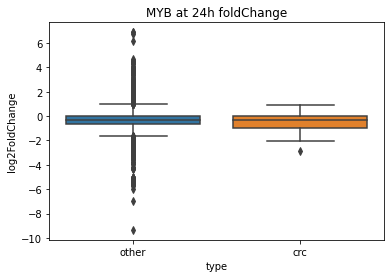

In [997]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{} at {} foldChange".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_1h_0_5_whiskers_logfch.pdf


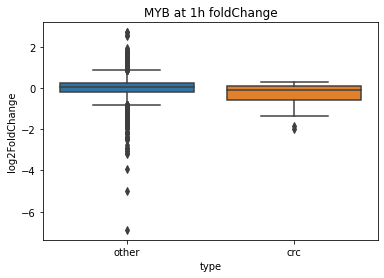

In [933]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{} at {} foldChange".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_24h_ERCCsamplewise_0_5_whiskers_baseMean.pdf


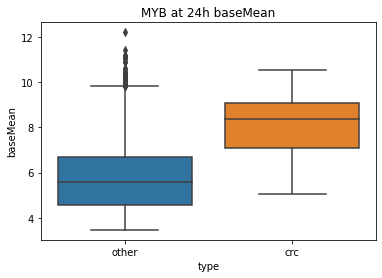

In [998]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{} at {} baseMean".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_1h_0_5_whiskers_baseMean.pdf


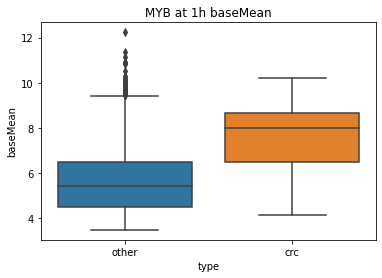

In [934]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{} at {} baseMean".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

### MYB 48h (ERCC normalized)

In [935]:
# MYB dTAG 48h
gene = "MYB"
version = "v1"
var_name = "time"
var = "48h"
scaling="ERCCsamplewise"

In [936]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_timecourse_v1_MYB_48h_ERCCsamplewise_0_5_deseq'

In [937]:
# read in DESeq outputs
resGene48_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene48_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [938]:
resGene48_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-9.177067,0.169092,-16.227412,0.000000,1.044586e-65
0.45,4.156353,-0.660514,0.413642,1.043450,0.019955,8.836985e-02
0.50,6.820628,-0.527618,0.463342,1.279505,0.047673,1.306414e-01
0.75,38.311320,0.000000,1.172454,2.724074,0.459947,4.867137e-01
1.00,4312.111329,7.572320,3.533812,17.662418,0.999993,9.999934e-01


In [939]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-13.122387,0.115783,-36.254878,0.000000,1.400734e-283
0.45,76.472395,-0.030543,0.224812,-0.383092,0.092286,1.456294e-01
0.50,117.277725,0.050040,0.243941,-0.141889,0.141922,2.129234e-01
0.75,621.434118,0.630694,0.677276,1.380892,0.524107,6.192351e-01
1.00,220675.124521,9.466558,3.533812,30.970142,0.999917,9.999174e-01


In [940]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene48_tc[resGene48_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,4.674980,-0.407504,0.336880,1.209642,2.264163e-01,3.397572e-01,NAT1,NAT1,other
3,4.656954,-1.357039,0.397788,3.411467,6.461432e-04,3.008671e-03,AAMP,AAMP,other
4,5.855560,-1.857605,0.269588,6.890522,5.558785e-12,2.521362e-10,AARS1,AARS1,other
5,3.962011,0.309172,0.440505,-0.701859,4.827674e-01,5.989987e-01,ABAT,ABAT,other
10,5.957719,-0.801783,0.271106,2.957454,3.101907e-03,1.106119e-02,ABCF1,ABCF1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_48h_ERCCsamplewise_0_5_whiskers_logfch.pdf


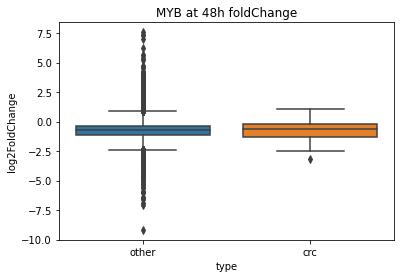

In [941]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{} at {} foldChange".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_MYB_48h_ERCCsamplewise_0_5_whiskers_baseMean.pdf


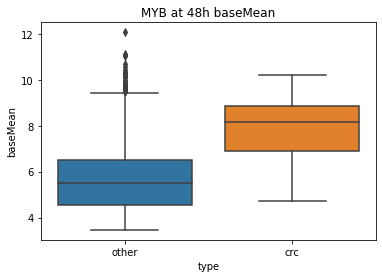

In [942]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{} at {} baseMean".format(gene, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

#### IRF2BP2 6h

In [123]:
resIRF2BP2_6h.baseMean.quantile([0,0.45,0.5,0.75,1])

0.00      0.000000
0.45      1.502293
0.50      2.125793
0.75      8.618345
1.00    792.305610
Name: baseMean, dtype: float64

In [124]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resIRF2BP2_6h[resIRF2BP2_6h.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,3.567919,-0.073534,0.523147,0.140560,0.888217,0.997053,AARS1,AARS1,other
9,4.759121,-0.802452,0.347349,2.310216,0.020876,0.931416,ABL1,ABL1,other
11,4.425603,-0.300262,0.394766,0.760606,0.446892,0.997053,ABL2,ABL2,other
22,4.141529,-0.134999,0.438179,0.308091,0.758013,0.997053,ACLY,ACLY,other
26,4.286644,-0.203152,0.398038,0.510383,0.609783,0.997053,ACP1,ACP1,other


Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_6h_logfch.pdf


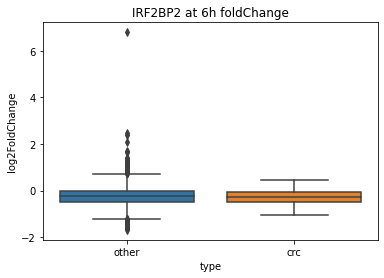

In [125]:
ax = sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("IRF2BP2 at 6h foldChange")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_6h_logfch.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_6h_baseMean.pdf


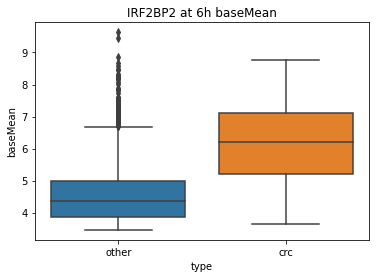

In [128]:
ax =sns.boxplot(data=res,x='type',y='baseMean').set_title("IRF2BP2 at 6h baseMean")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_6h_baseMean.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

## Scatter plot comparison

### MYB 1h vs 2h

In [1003]:
# MYB dTAG 1h vs 2h
gene = "MYB"
version = "v1"
var_name = "time"
comp_vars = ["1h", "2h"]
scaling=None

In [1002]:
deseq_res_file_prefixes = ["{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)]))) for var in comp_vars]
deseq_res_file_prefixes

['MYB_degraded_timecourse_v1_MYB_1h_0_5_deseq',
 'MYB_degraded_timecourse_v1_MYB_2h_0_5_deseq']

In [952]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [133]:
mix = pd.DataFrame()
mix["gene_id"] = resIRF2BP2_3h["gene_id"]
mix['IRF2BP2 3h'] = resIRF2BP2_3h.log2FoldChange
mix['IRF2BP2 6h'] = resIRF2BP2_6h.log2FoldChange

In [135]:
print(mix.shape)
mix.head()

(15139, 3)


,gene_id,IRF2BP2 3h,IRF2BP2 6h
0,NAT1,-0.556462,1.835873
1,AAMP,0.315619,0.117255
2,AARS1,-0.109872,-0.073534
3,ABAT,-0.946852,-1.138852
4,ABCA1,-0.439957,-1.167510


In [143]:
scatter_folder = '../results/'+project+'/plots/'+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)
print(scatter_folder)


genepyPlot.scatter(mix[['IRF2BP2 3h', 'IRF2BP2 6h']].values[:12000],
                   mix['gene_id'].values.tolist()[:12000], radi= 0.06, alpha=0.3,
                   colors = [0 if i in crc else 1 for i in mix['gene_id'].values.tolist()[:12000]],
                   xname="IRF2BP2 3h", yname="IRF2BP2 6h",
                   folder=scatter_folder,
                   title='IRF2BP2 3h vs 6h differences in logFoldChange')

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5


Figure(id='2237', ...)

## Regular volcanos

In [163]:
from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

#### IRF2BP2 3h

In [144]:
res_file = "../results/"+project+"/"+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)+'_IRF2BP2_3h_deseq.csv'
resIRF2BP2_3h.to_csv(res_file)

print("Saved DESeq results to: {}".format(res_file))

Saved DESeq results to: ../results/IRF2BP2_degraded_YKL_v1/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_IRF2BP2_3h_deseq.csv


In [146]:
resIRF2BP2_3h.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,5.019967,-0.556462,0.738811,0.753185,0.451339,NaN,NAT1,NAT1
1,14.549214,0.315619,0.385422,-0.818892,0.412848,0.644171,AAMP,AAMP
2,16.044563,-0.109872,0.395827,0.277577,0.781337,0.885655,AARS1,AARS1
3,1.695828,-0.946852,1.260507,0.751167,0.452552,NaN,ABAT,ABAT
4,6.332239,-0.439957,0.569045,0.773150,0.439434,NaN,ABCA1,ABCA1


In [165]:
volcano_folder = "../results/{0}/plots/{0}_{1}_{2}_{3}".format(project, scaling, minvar_toremove, mincount_toremove)
print(volcano_folder)

genepyPlot.volcano(resIRF2BP2_3h, tohighlight=crc, searchbox=True, 
                   title='MV411 IRF2BP2 dTAG at 3h', 
                   folder=volcano_folder)

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5
Attempting to save figure to ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_MV411_IRF2BP2_dTAG_at_3h_volcano.html


Column(id='6969', ...)

#### IRF2BP2 6h

In [145]:
res_file = "../results/"+project+"/"+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)+'_IRF2BP2_6h_deseq.csv'
resIRF2BP2_6h.to_csv(res_file)

print("Saved DESeq results to: {}".format(res_file))

Saved DESeq results to: ../results/IRF2BP2_degraded_YKL_v1/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_IRF2BP2_6h_deseq.csv


In [147]:
resIRF2BP2_6h.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.679474,1.835873,1.882485,-0.975239,0.329442,0.997053,NAT1,NAT1
1,6.895730,0.117255,0.620358,-0.189013,0.850083,0.997053,AAMP,AAMP
2,10.859066,-0.073534,0.523147,0.140560,0.888217,0.997053,AARS1,AARS1
3,0.633716,-1.138852,2.091871,0.544418,0.586154,0.997053,ABAT,ABAT
4,1.383080,-1.167510,1.382278,0.844627,0.398319,0.997053,ABCA1,ABCA1


In [164]:
volcano_folder = "../results/{0}/plots/{0}_{1}_{2}_{3}".format(project, scaling, minvar_toremove, mincount_toremove)
#volcano_folder = '../results/'+project+'/plots/'+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)
print(volcano_folder)

genepyPlot.volcano(resIRF2BP2_6h, tohighlight=crc, searchbox=True, 
                   title='MV411 IRF2BP2 dTAG at 6h', 
                   folder=volcano_folder)

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5
Attempting to save figure to ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_MV411_IRF2BP2_dTAG_at_6h_volcano.html


Column(id='6539', ...)